In [1]:

from ai2_internal import api
from mmda.predictors.lp_predictors import LayoutParserPredictor

# from project root:
# > pip install -e '.[dev,lp_predictors]'
# also:
# `pip install -i https://pip.s2.allenai.org/simple spp_client==0.3.1`

weights_paths = ["lp://efficientdet/PubLayNet", "lp://efficientdet/MFD"]
# weights_paths = ["lp://efficientdet/PubLayNet"]
# weights_paths = ["lp://efficientdet/MFD"]

lp_predictors = [
    LayoutParserPredictor.from_pretrained(weights_path, device=None)
    for weights_path in weights_paths
]


/Users/angelez/miniconda3/envs/mmda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# test data since no success from spp yet (need to find right sha and sources probably)
from spp_client.client import DocumentAnnotations, SppClient

client = SppClient.mk(env="dev")

sha = "72b37044a17c9210ed56c2cc7b9a737b1385311b"
hmmm = "layout-parser-0.0.2|pdf-plumber-0.0.8"

pdf_plumber = "pdf-plumber-0.0.8"


doc = client.get_mmda_doc(
    sha,
    pdf_plumber,
    [], # not requesting any other doc annos besides plumber stuffs
    include_images=True
)


In [3]:
box_groups = []
# we currently run 2 predictors 
for predictor in lp_predictors:
    box_groups.extend(predictor.predict(doc))

100%|██████████| 17/17 [00:12<00:00,  1.34it/s]


In [4]:
for bg in box_groups:
    print(bg.to_json())

{'boxes': [{'left': 0.5141462386148684, 'top': 0.7321552067119652, 'width': 0.3988358480222585, 'height': 0.20500672244173052, 'page': 0}], 'metadata': {'type': 'Text'}}
{'boxes': [{'left': 0.5140513962576441, 'top': 0.4040808744661957, 'width': 0.3980439092784774, 'height': 0.27465188914331895, 'page': 0}], 'metadata': {'type': 'Text'}}
{'boxes': [{'left': 0.0985893451950048, 'top': 0.42775510980403897, 'width': 0.3973057179110956, 'height': 0.30696941974976055, 'page': 0}], 'metadata': {'type': 'Text'}}
{'boxes': [{'left': 0.10499685360226861, 'top': 0.7357636862178719, 'width': 0.3912122735929726, 'height': 0.09999546328723659, 'page': 0}], 'metadata': {'type': 'Text'}}
{'boxes': [{'left': 0.1108261538579887, 'top': 0.2894228646581657, 'width': 0.8268415409929519, 'height': 0.08962763254060904, 'page': 0}], 'metadata': {'type': 'Text'}}
{'boxes': [{'left': 0.5164406746378783, 'top': 0.700397281963402, 'width': 0.29551967538609036, 'height': 0.013865581721942848, 'page': 0}], 'metada

In [5]:
#imports
from collections import defaultdict
import layoutparser.elements as lpe
import layoutparser.visualization as lpv
from typing import List

#function to create viz-able rectangles from list of box_groups, provided mmda doc that has images
def make_rectangles(box_groups, mmda_doc):

    result_text_blocks_by_page = defaultdict(list)
    original_boxes_by_page = defaultdict(list)
    page_sizes = dict()
    
    for bg in box_groups:
        # if bg.metadata.type == "Equation" or bg.metadata.type == "Figure":
        #     continue
        for box in bg.boxes:
            if box.page not in page_sizes:
                page_sizes[box.page] = mmda_doc.images[box.page].size
            page_w, page_h = page_sizes[box.page]

            # color = 'relevant' if bib.id in relevant_bib_entry_ids else 'other'

            rect = lpe.Rectangle(
                    box.l * page_w,
                    box.t * page_h,
                    (box.l + box.w) * page_w,
                    (box.t + box.h) * page_h
                )
            result_text_blocks_by_page[box.page].append(lpe.TextBlock(
                rect,
                id=bg.metadata.type #,
                # type=color
            ))
    return result_text_blocks_by_page


In [6]:
import cv2
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure

def draw_text_blocks(page, text_blocks_dictionary, color_map=None, id_map=None):
    image = doc.images[page]

    if color_map is None:
        color_map={'relevant': 'blue', 'other': '#f7ede2'}

    if image:
        return lpv.draw_box(image,
                            text_blocks_dictionary[page],
                            color_map=color_map,
                            show_element_id=True,
                            id_font_size=10,
                            id_text_color='blue'
                            )
    
    return None

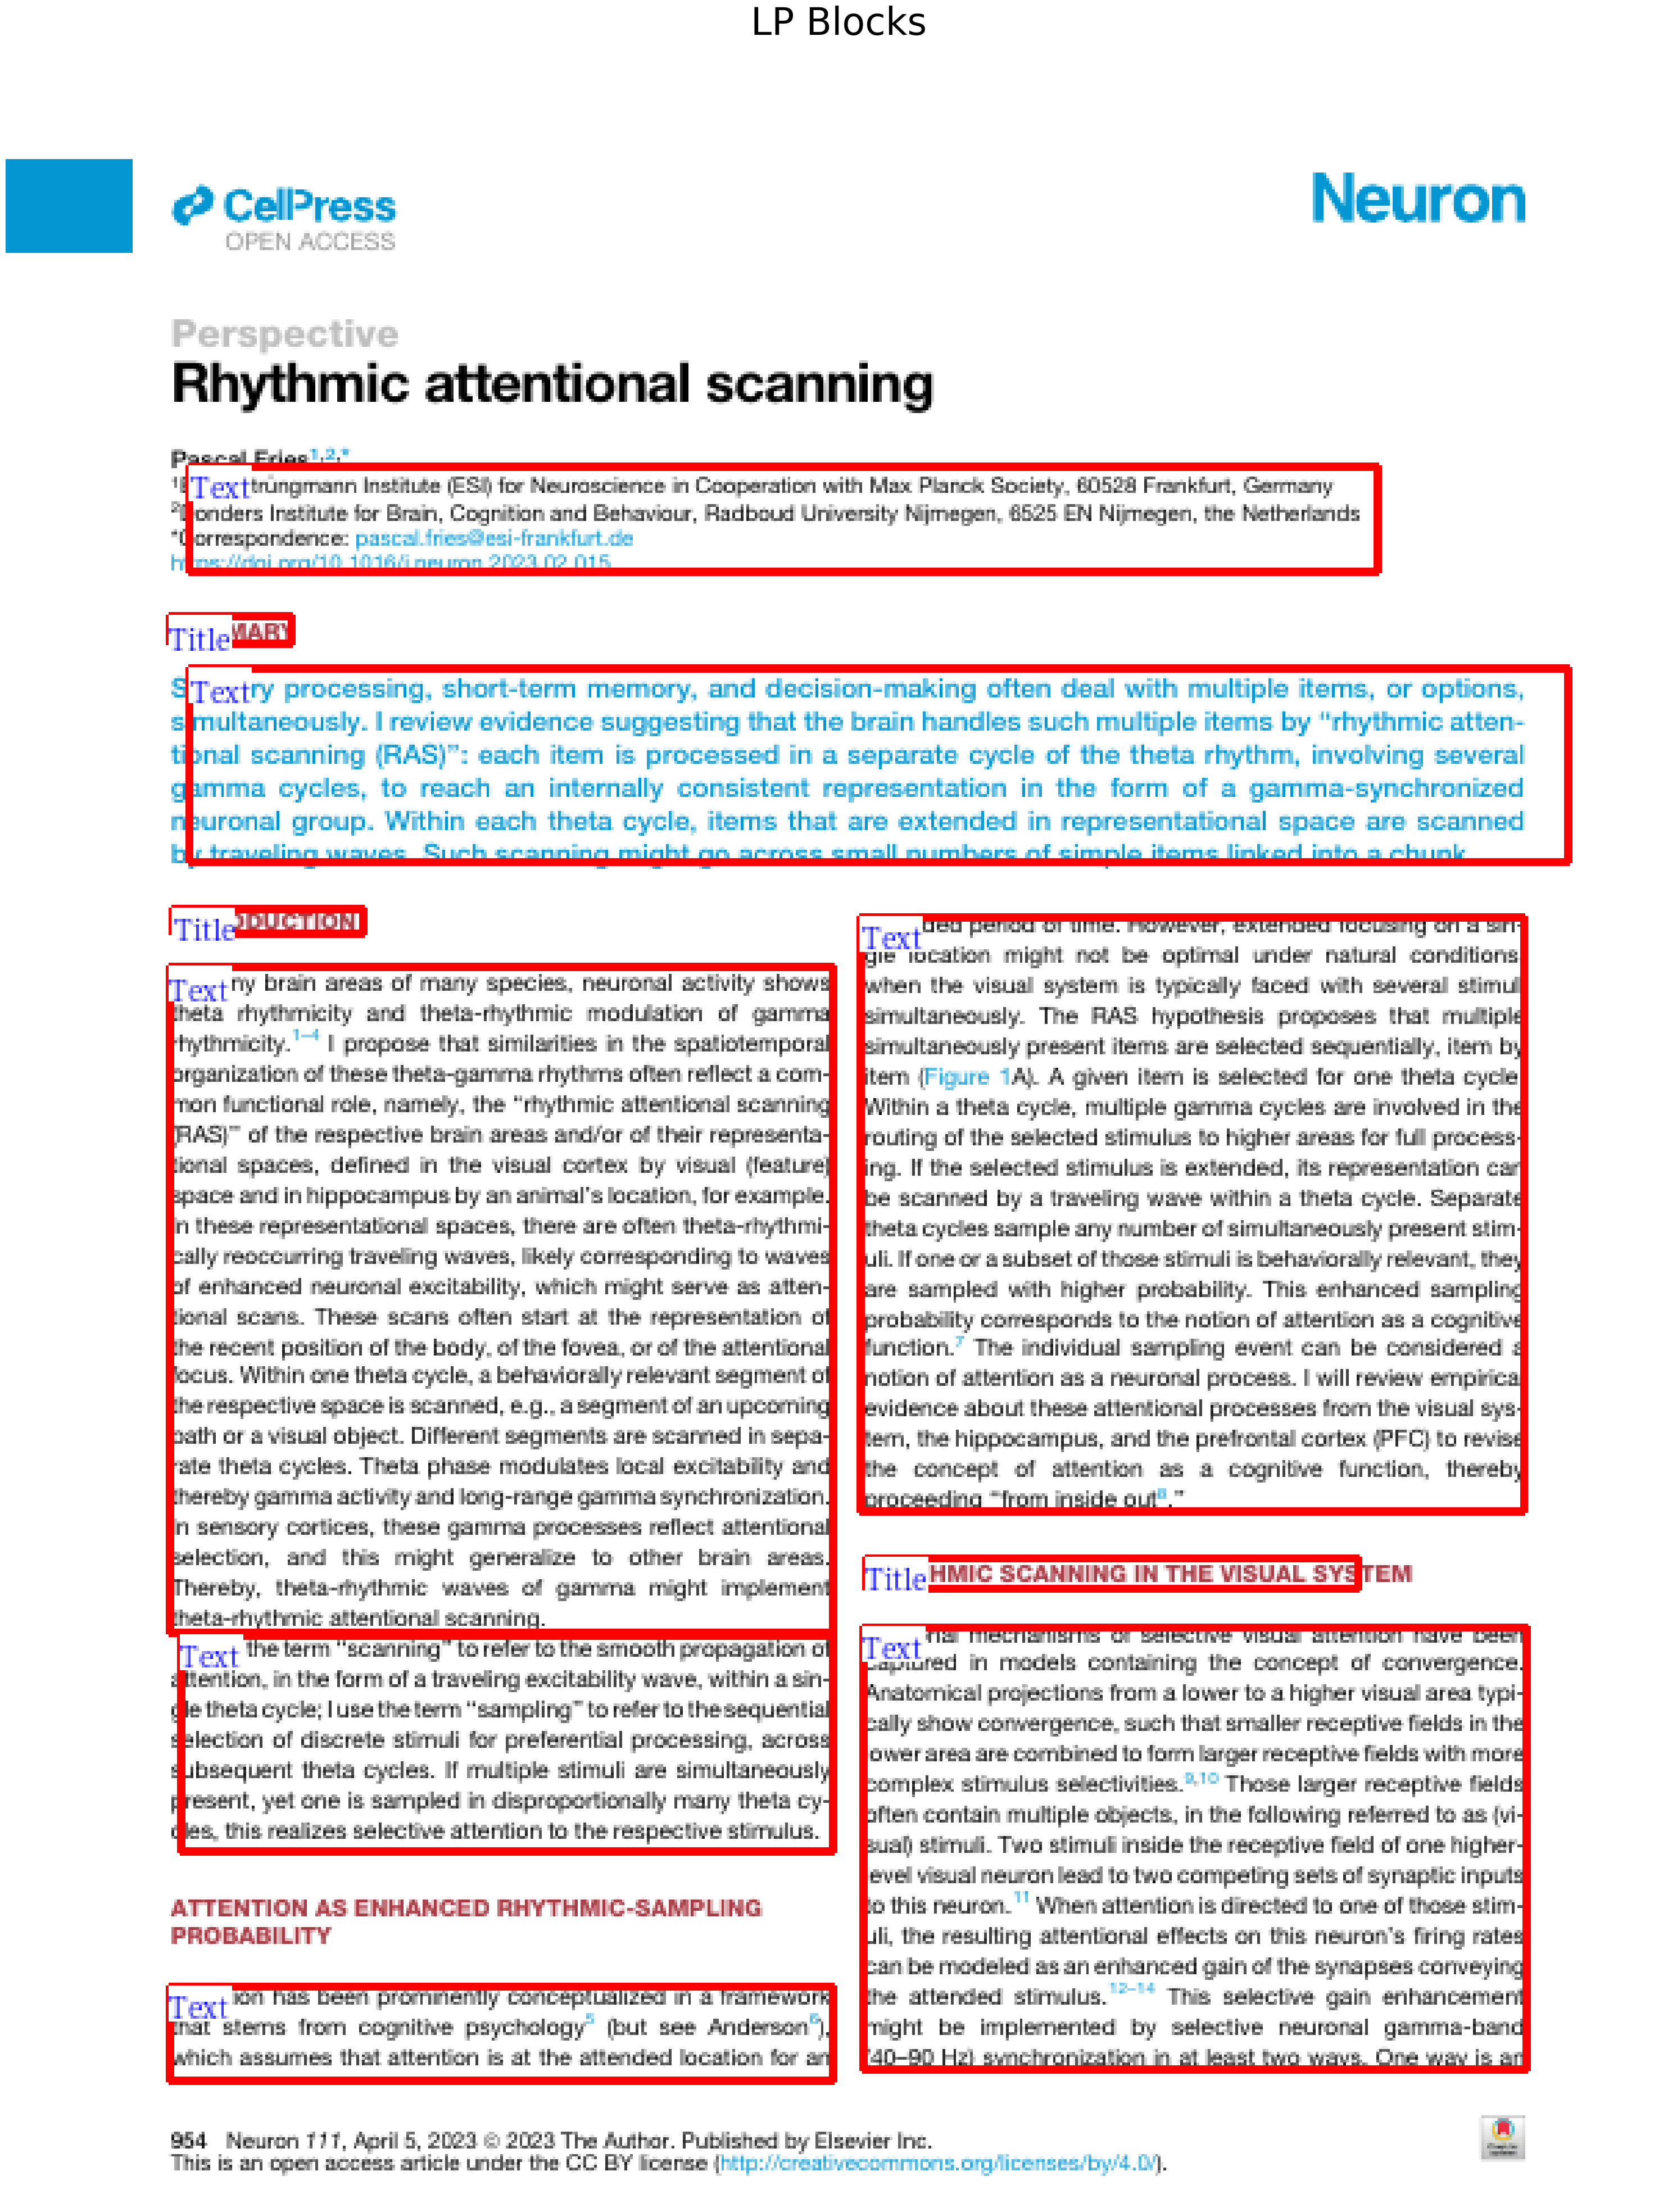

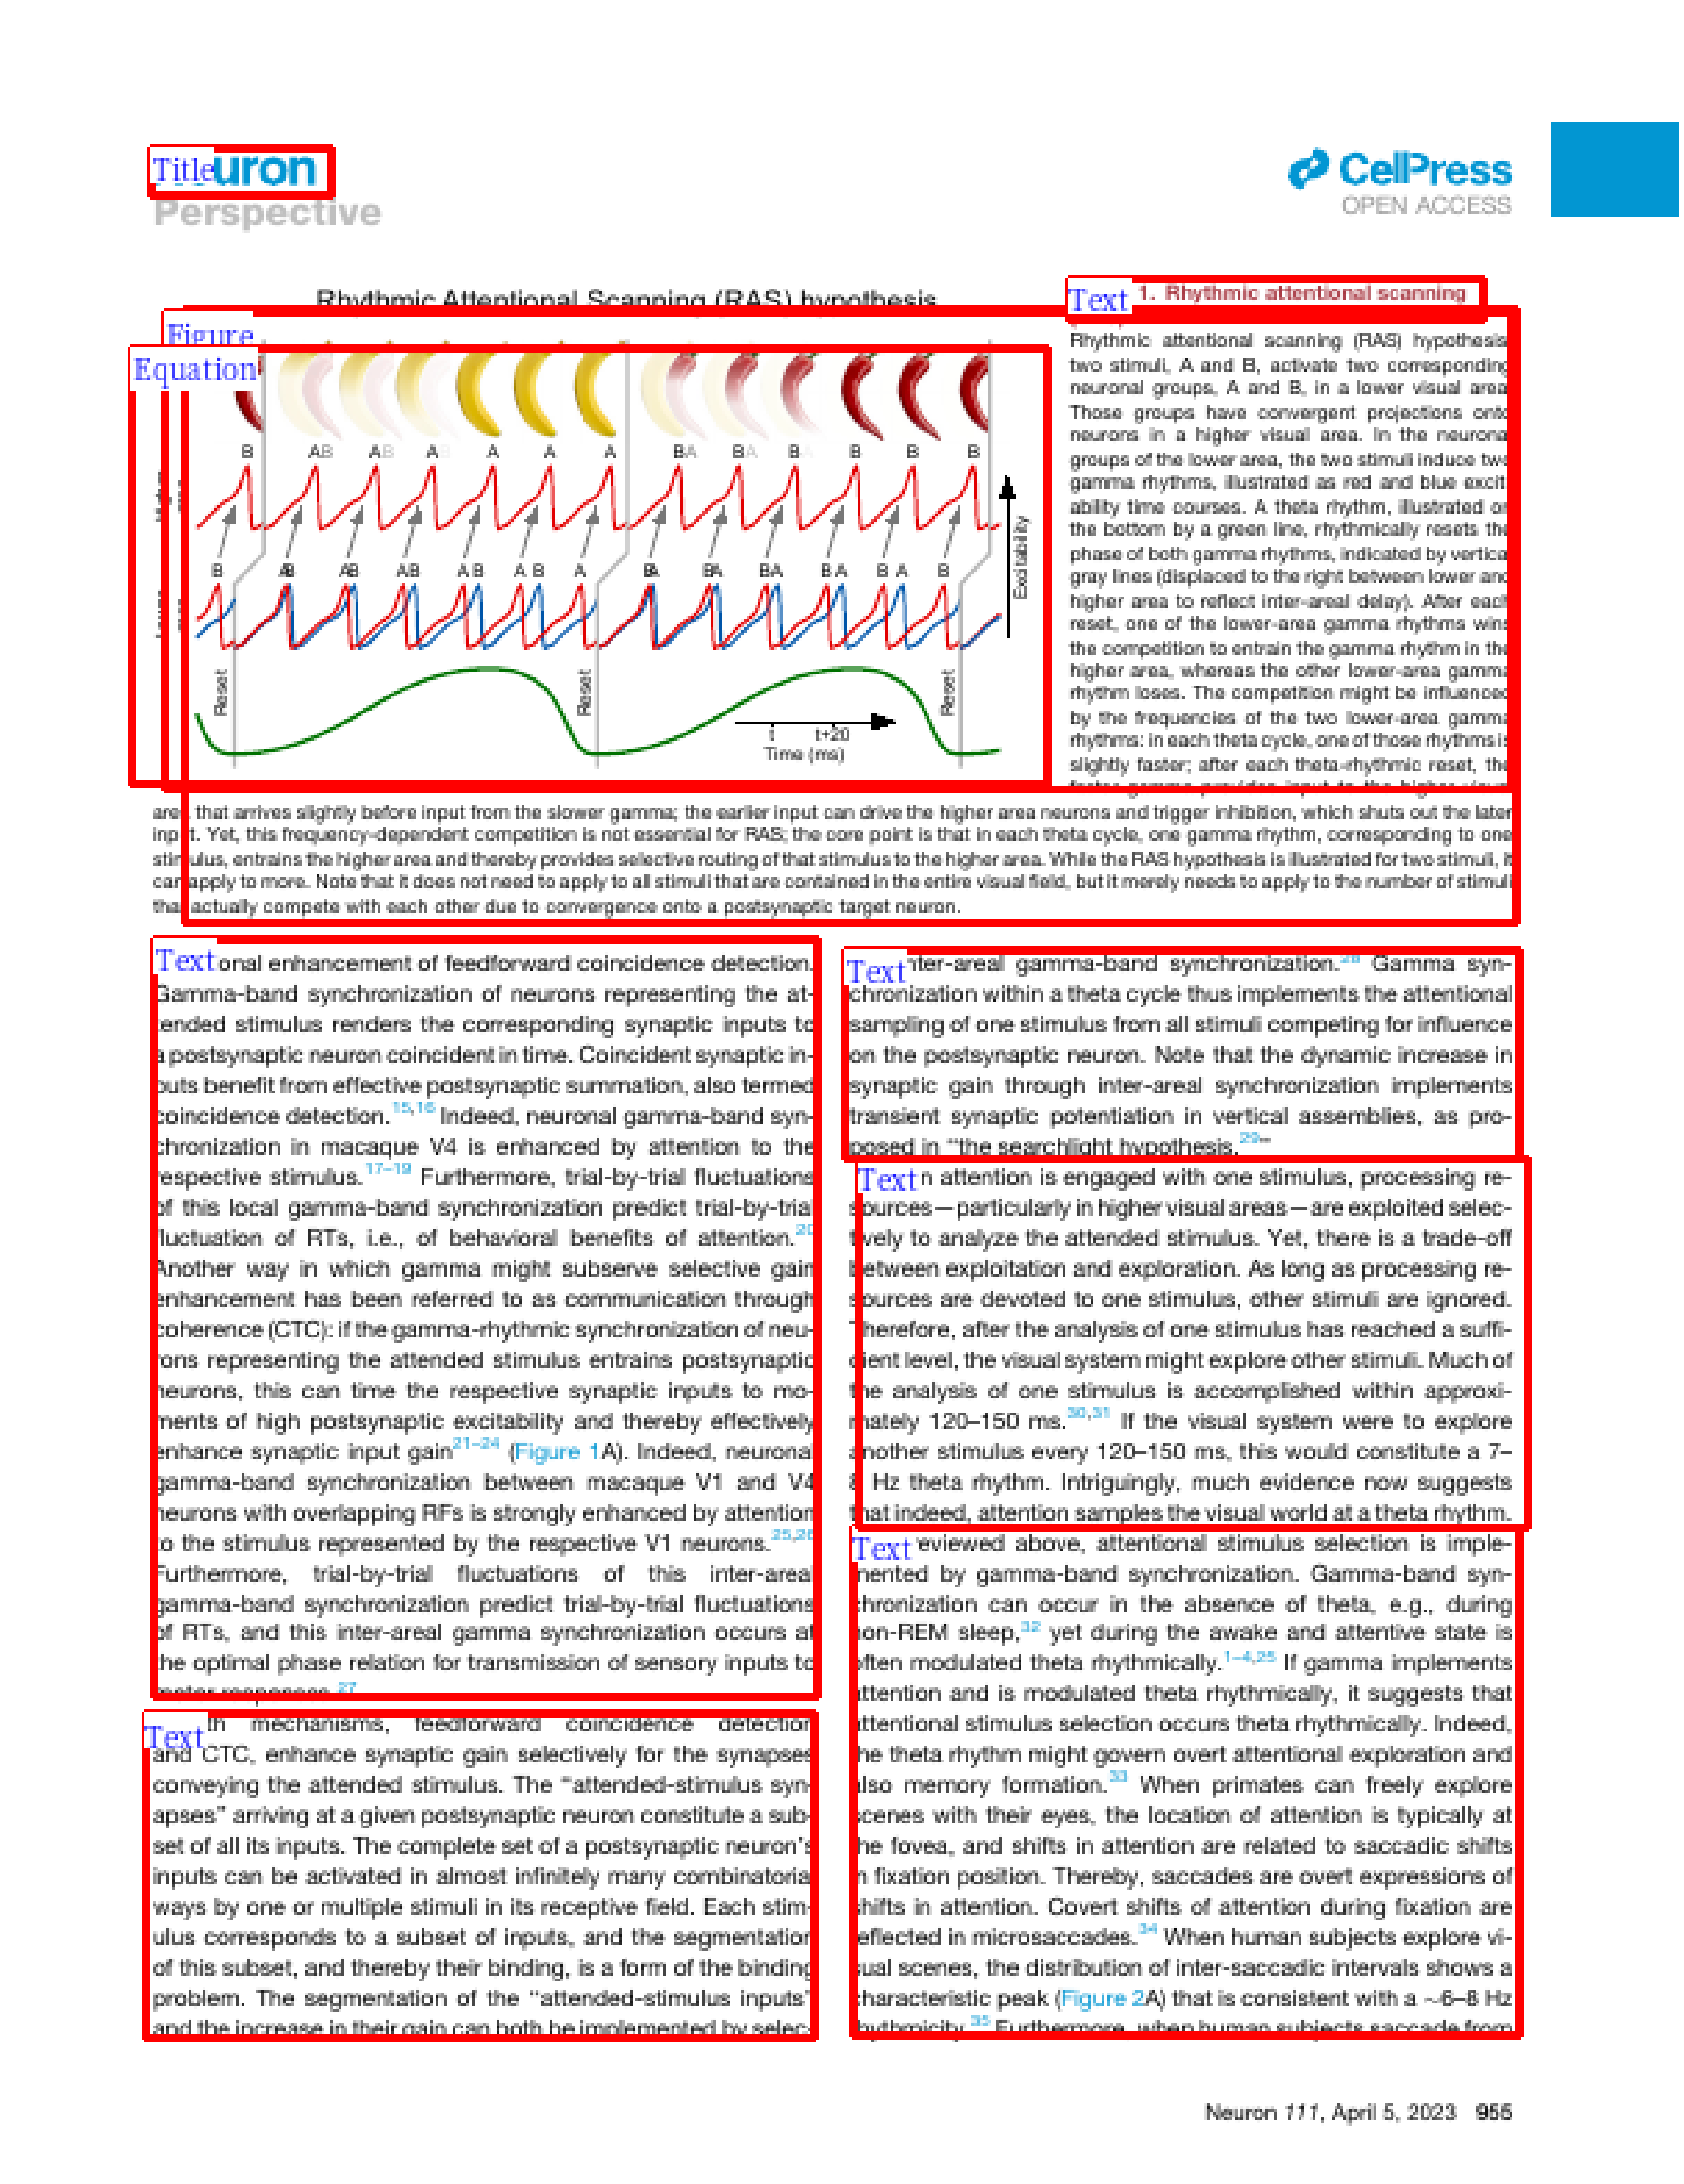

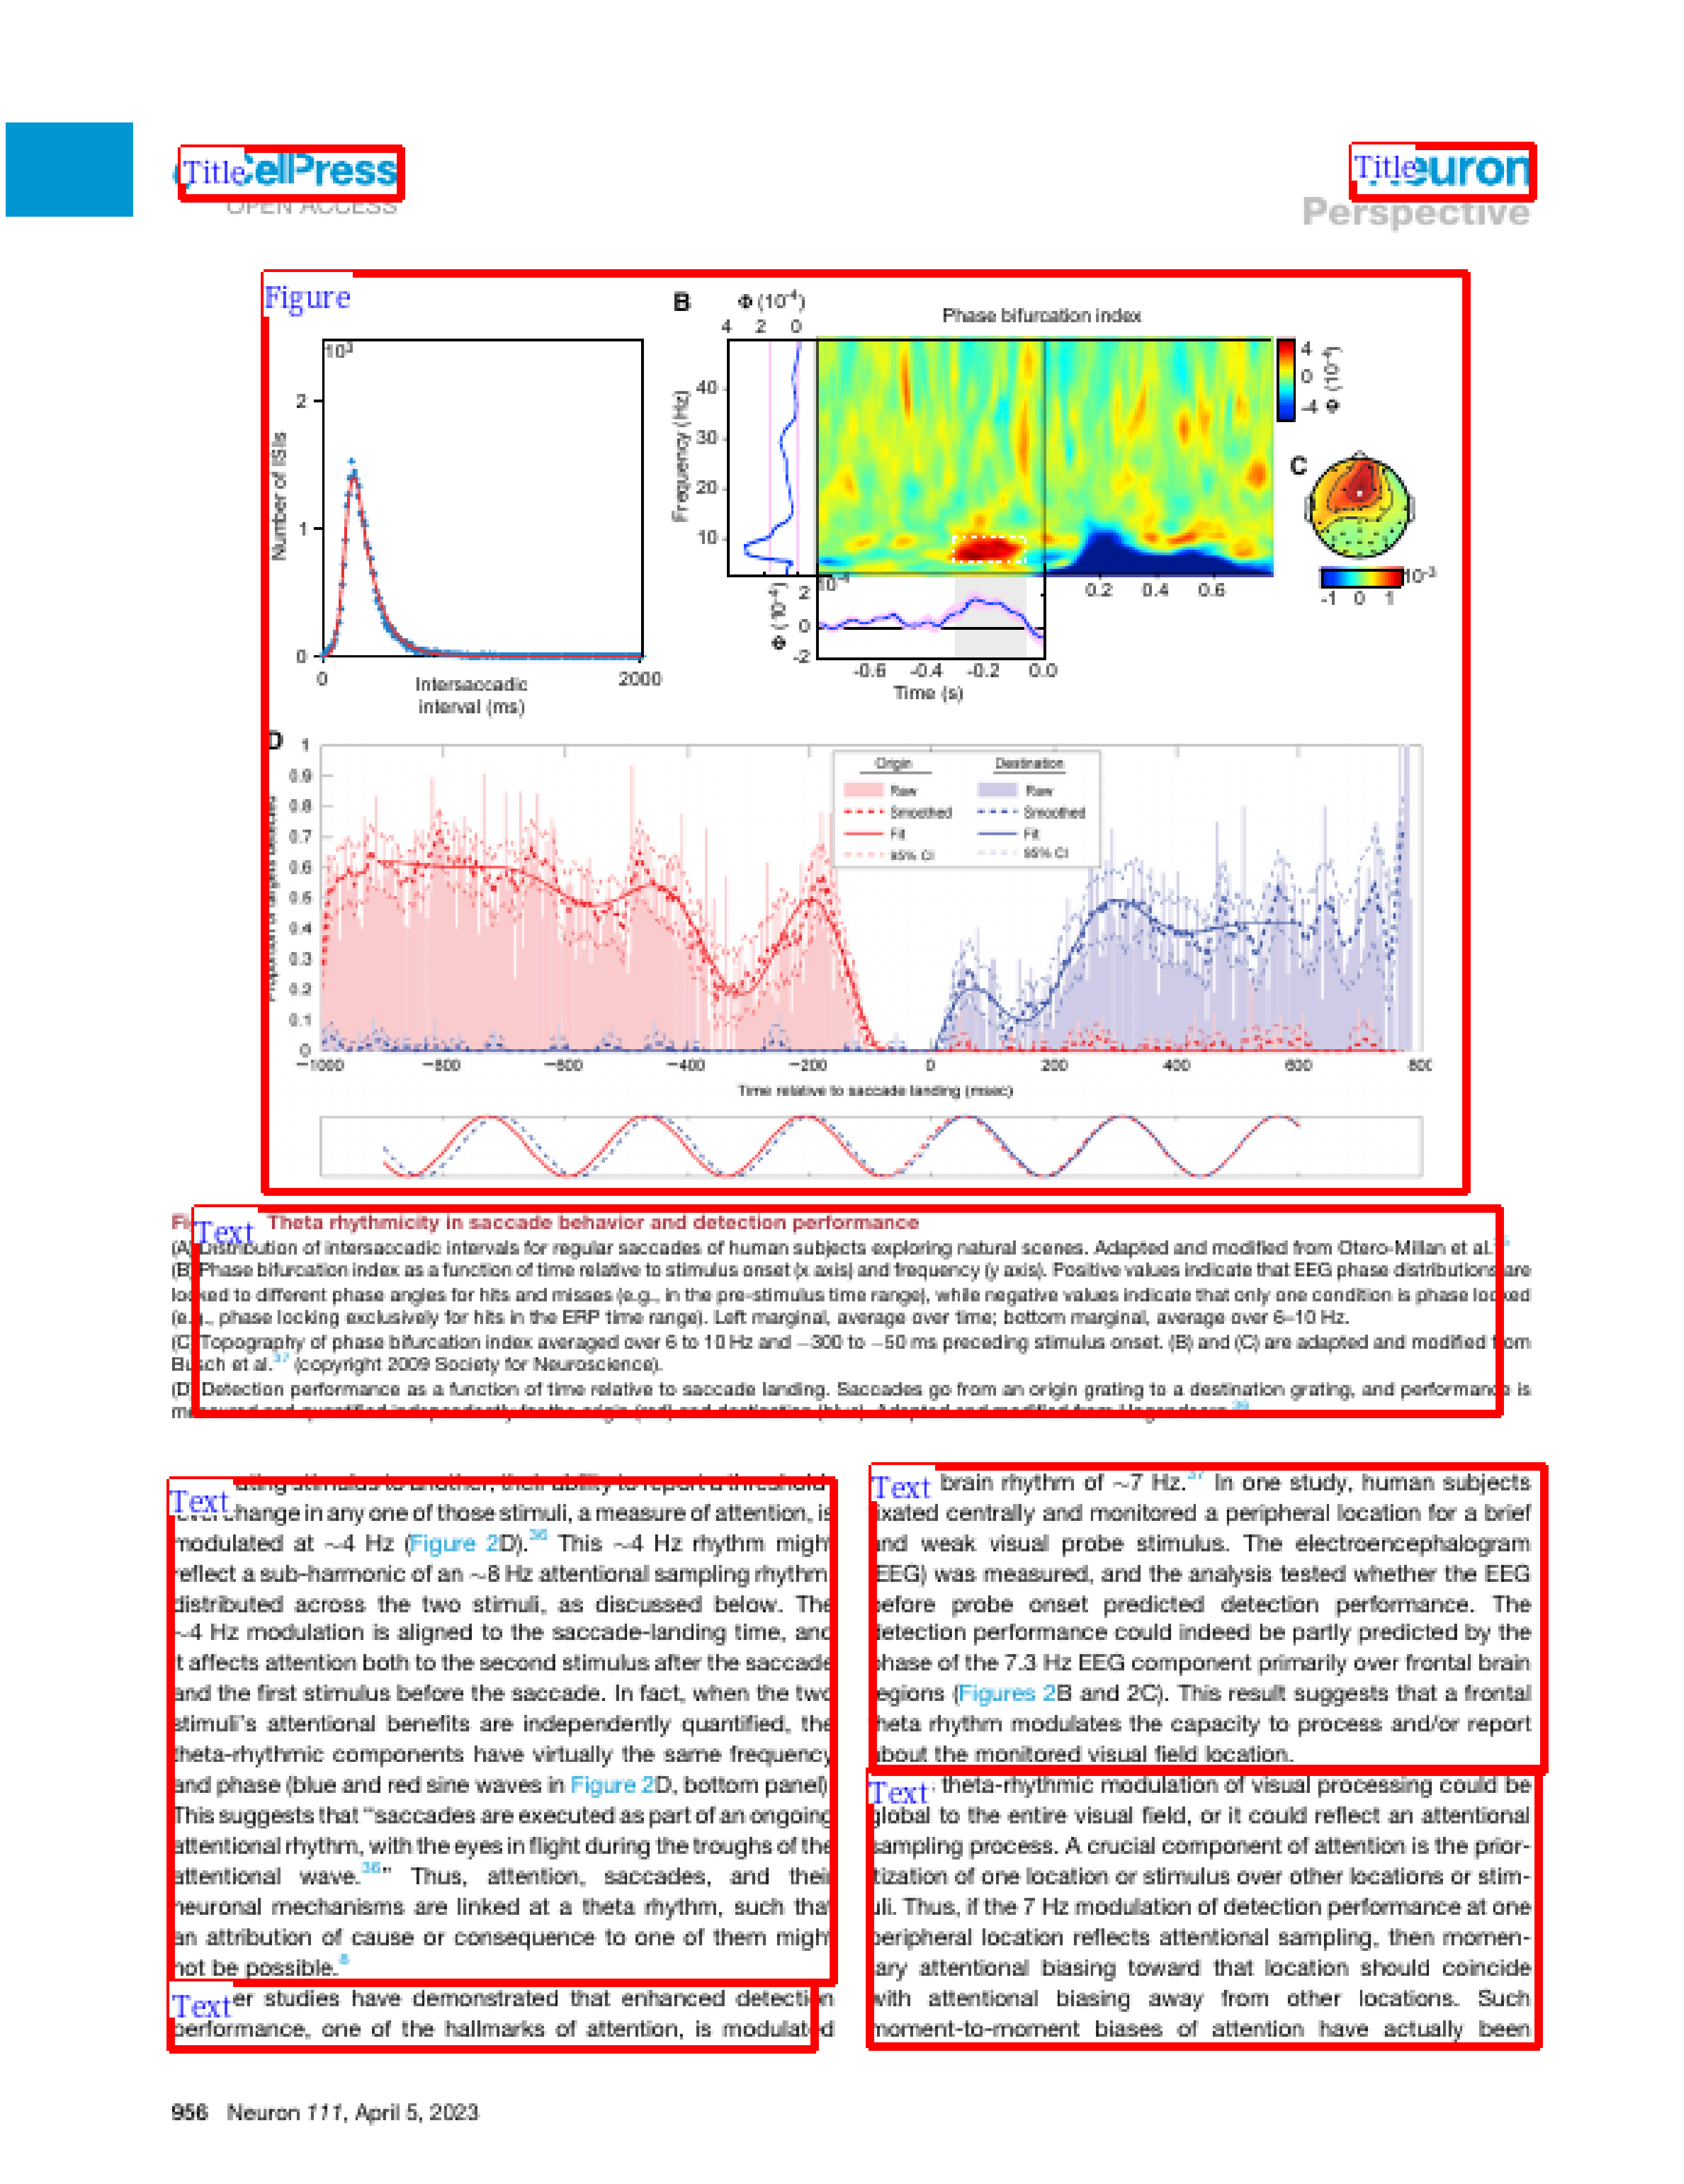

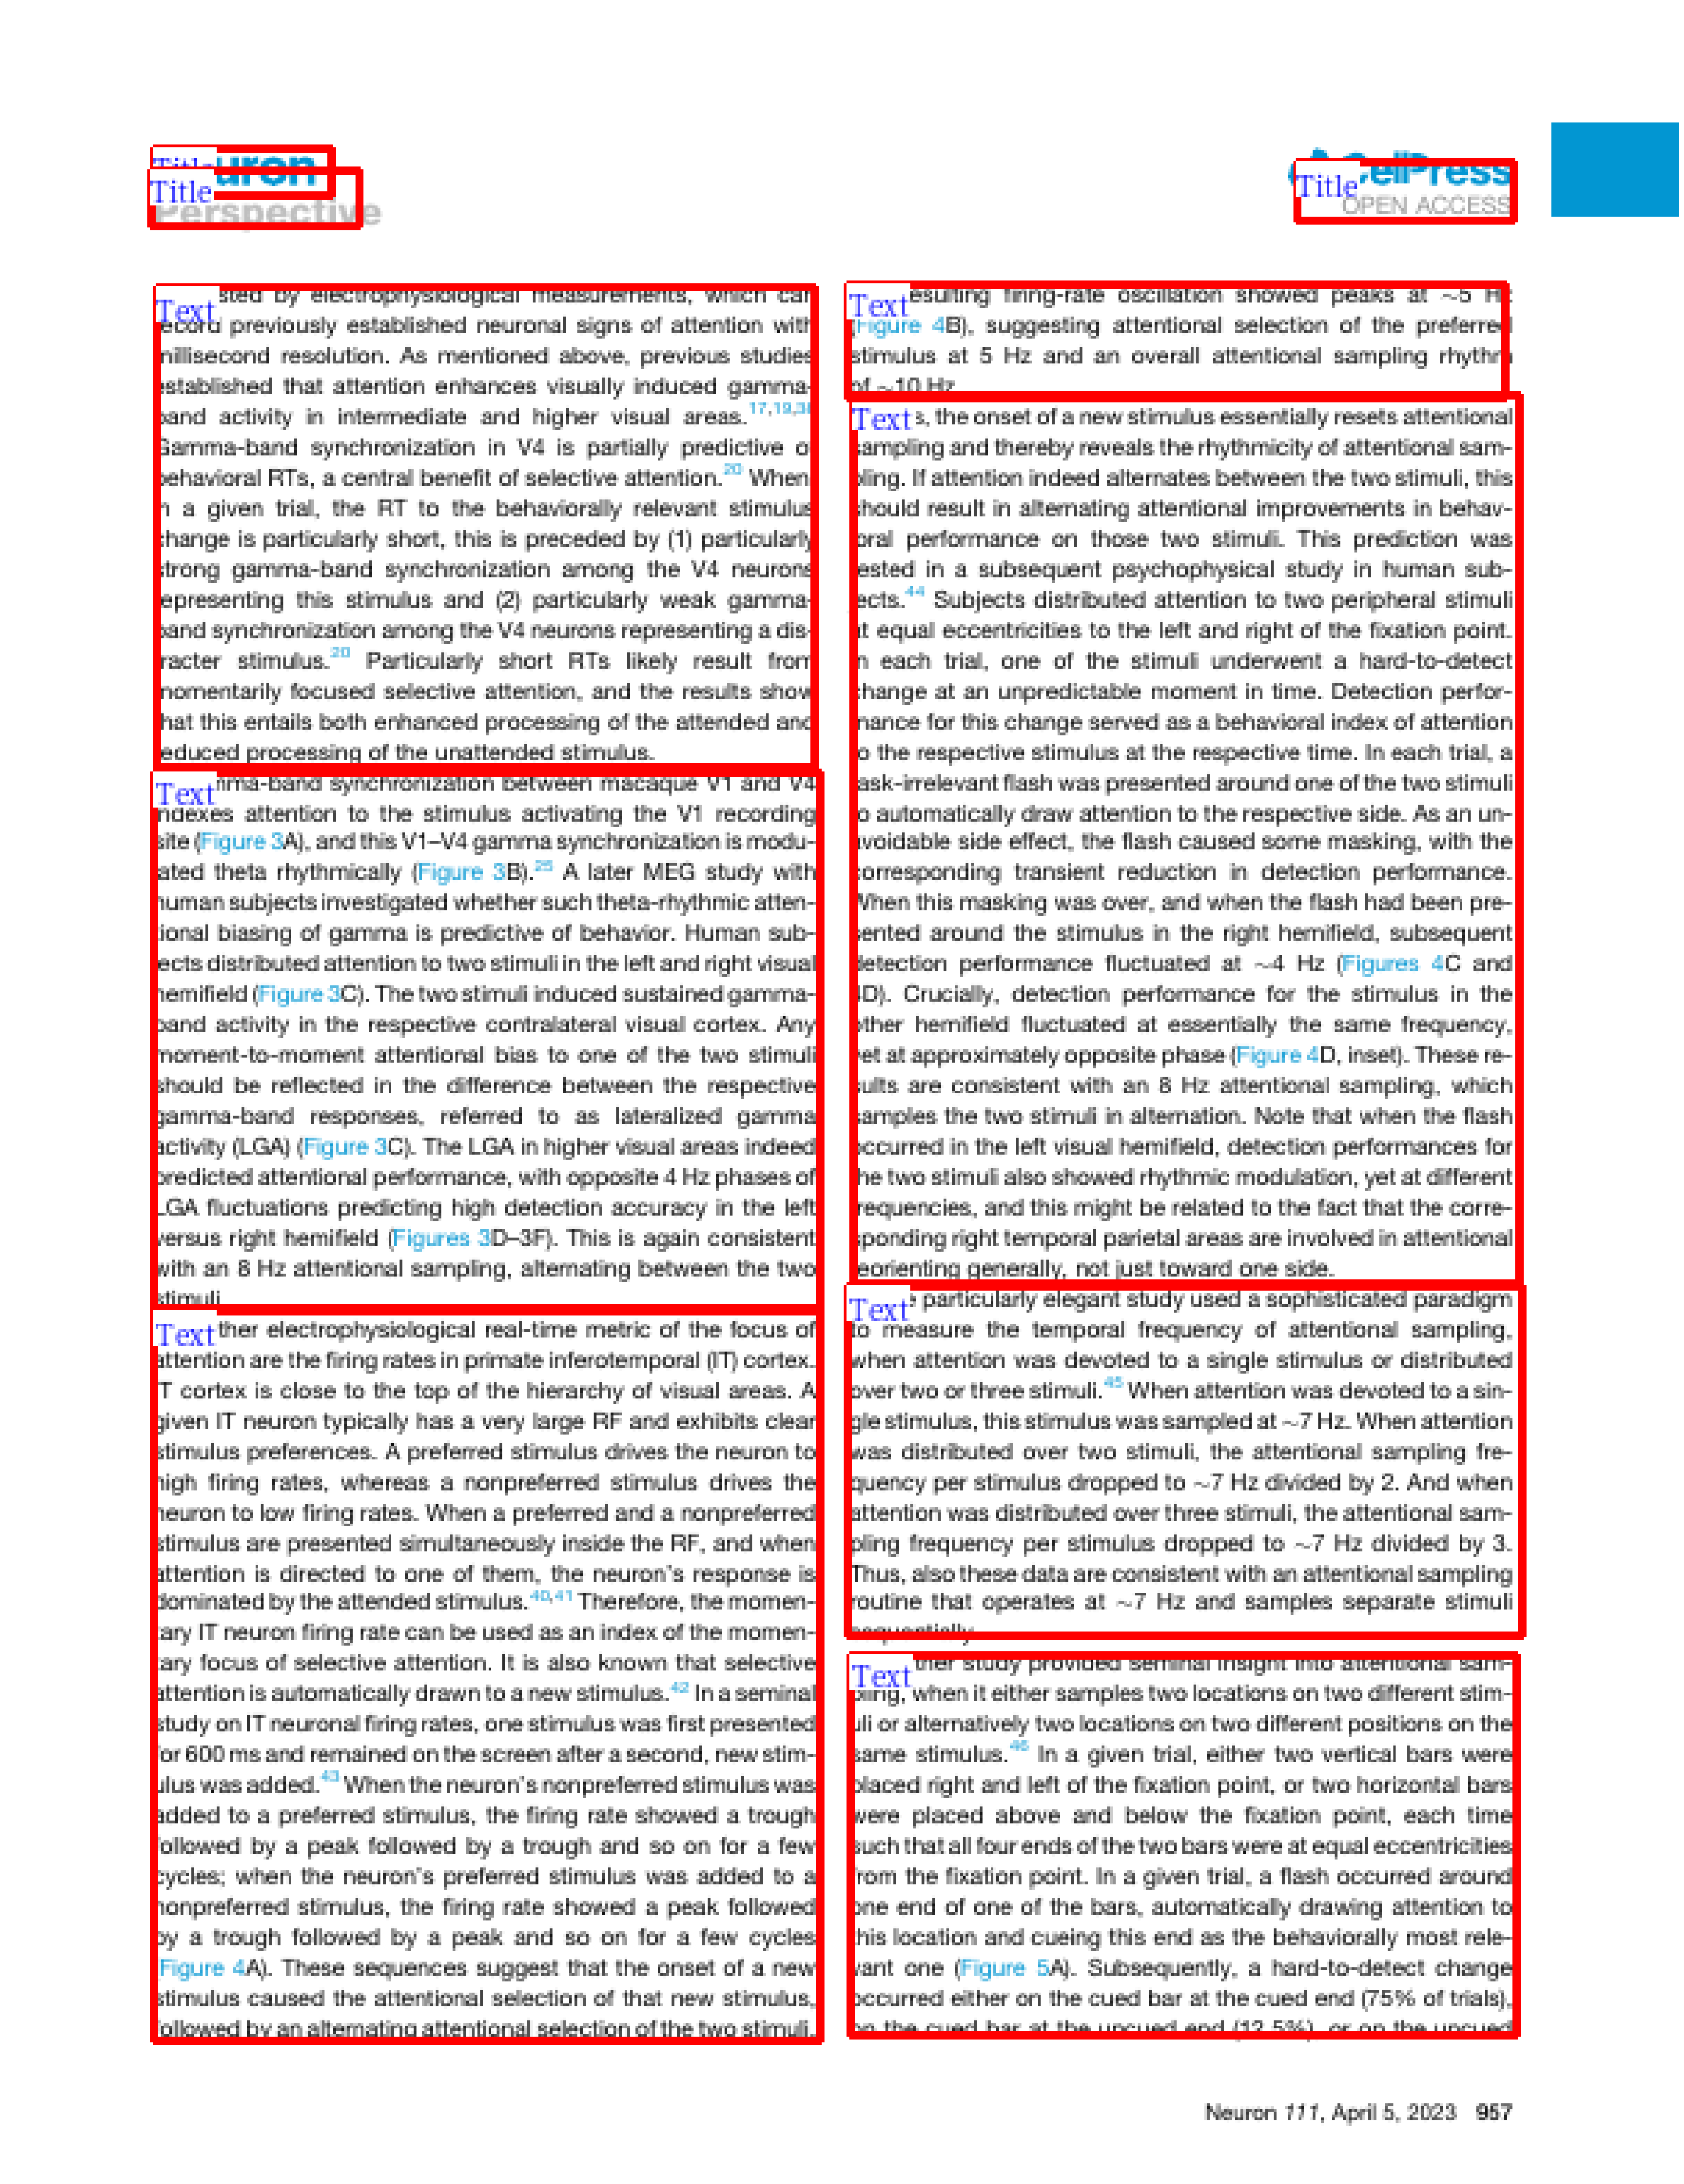

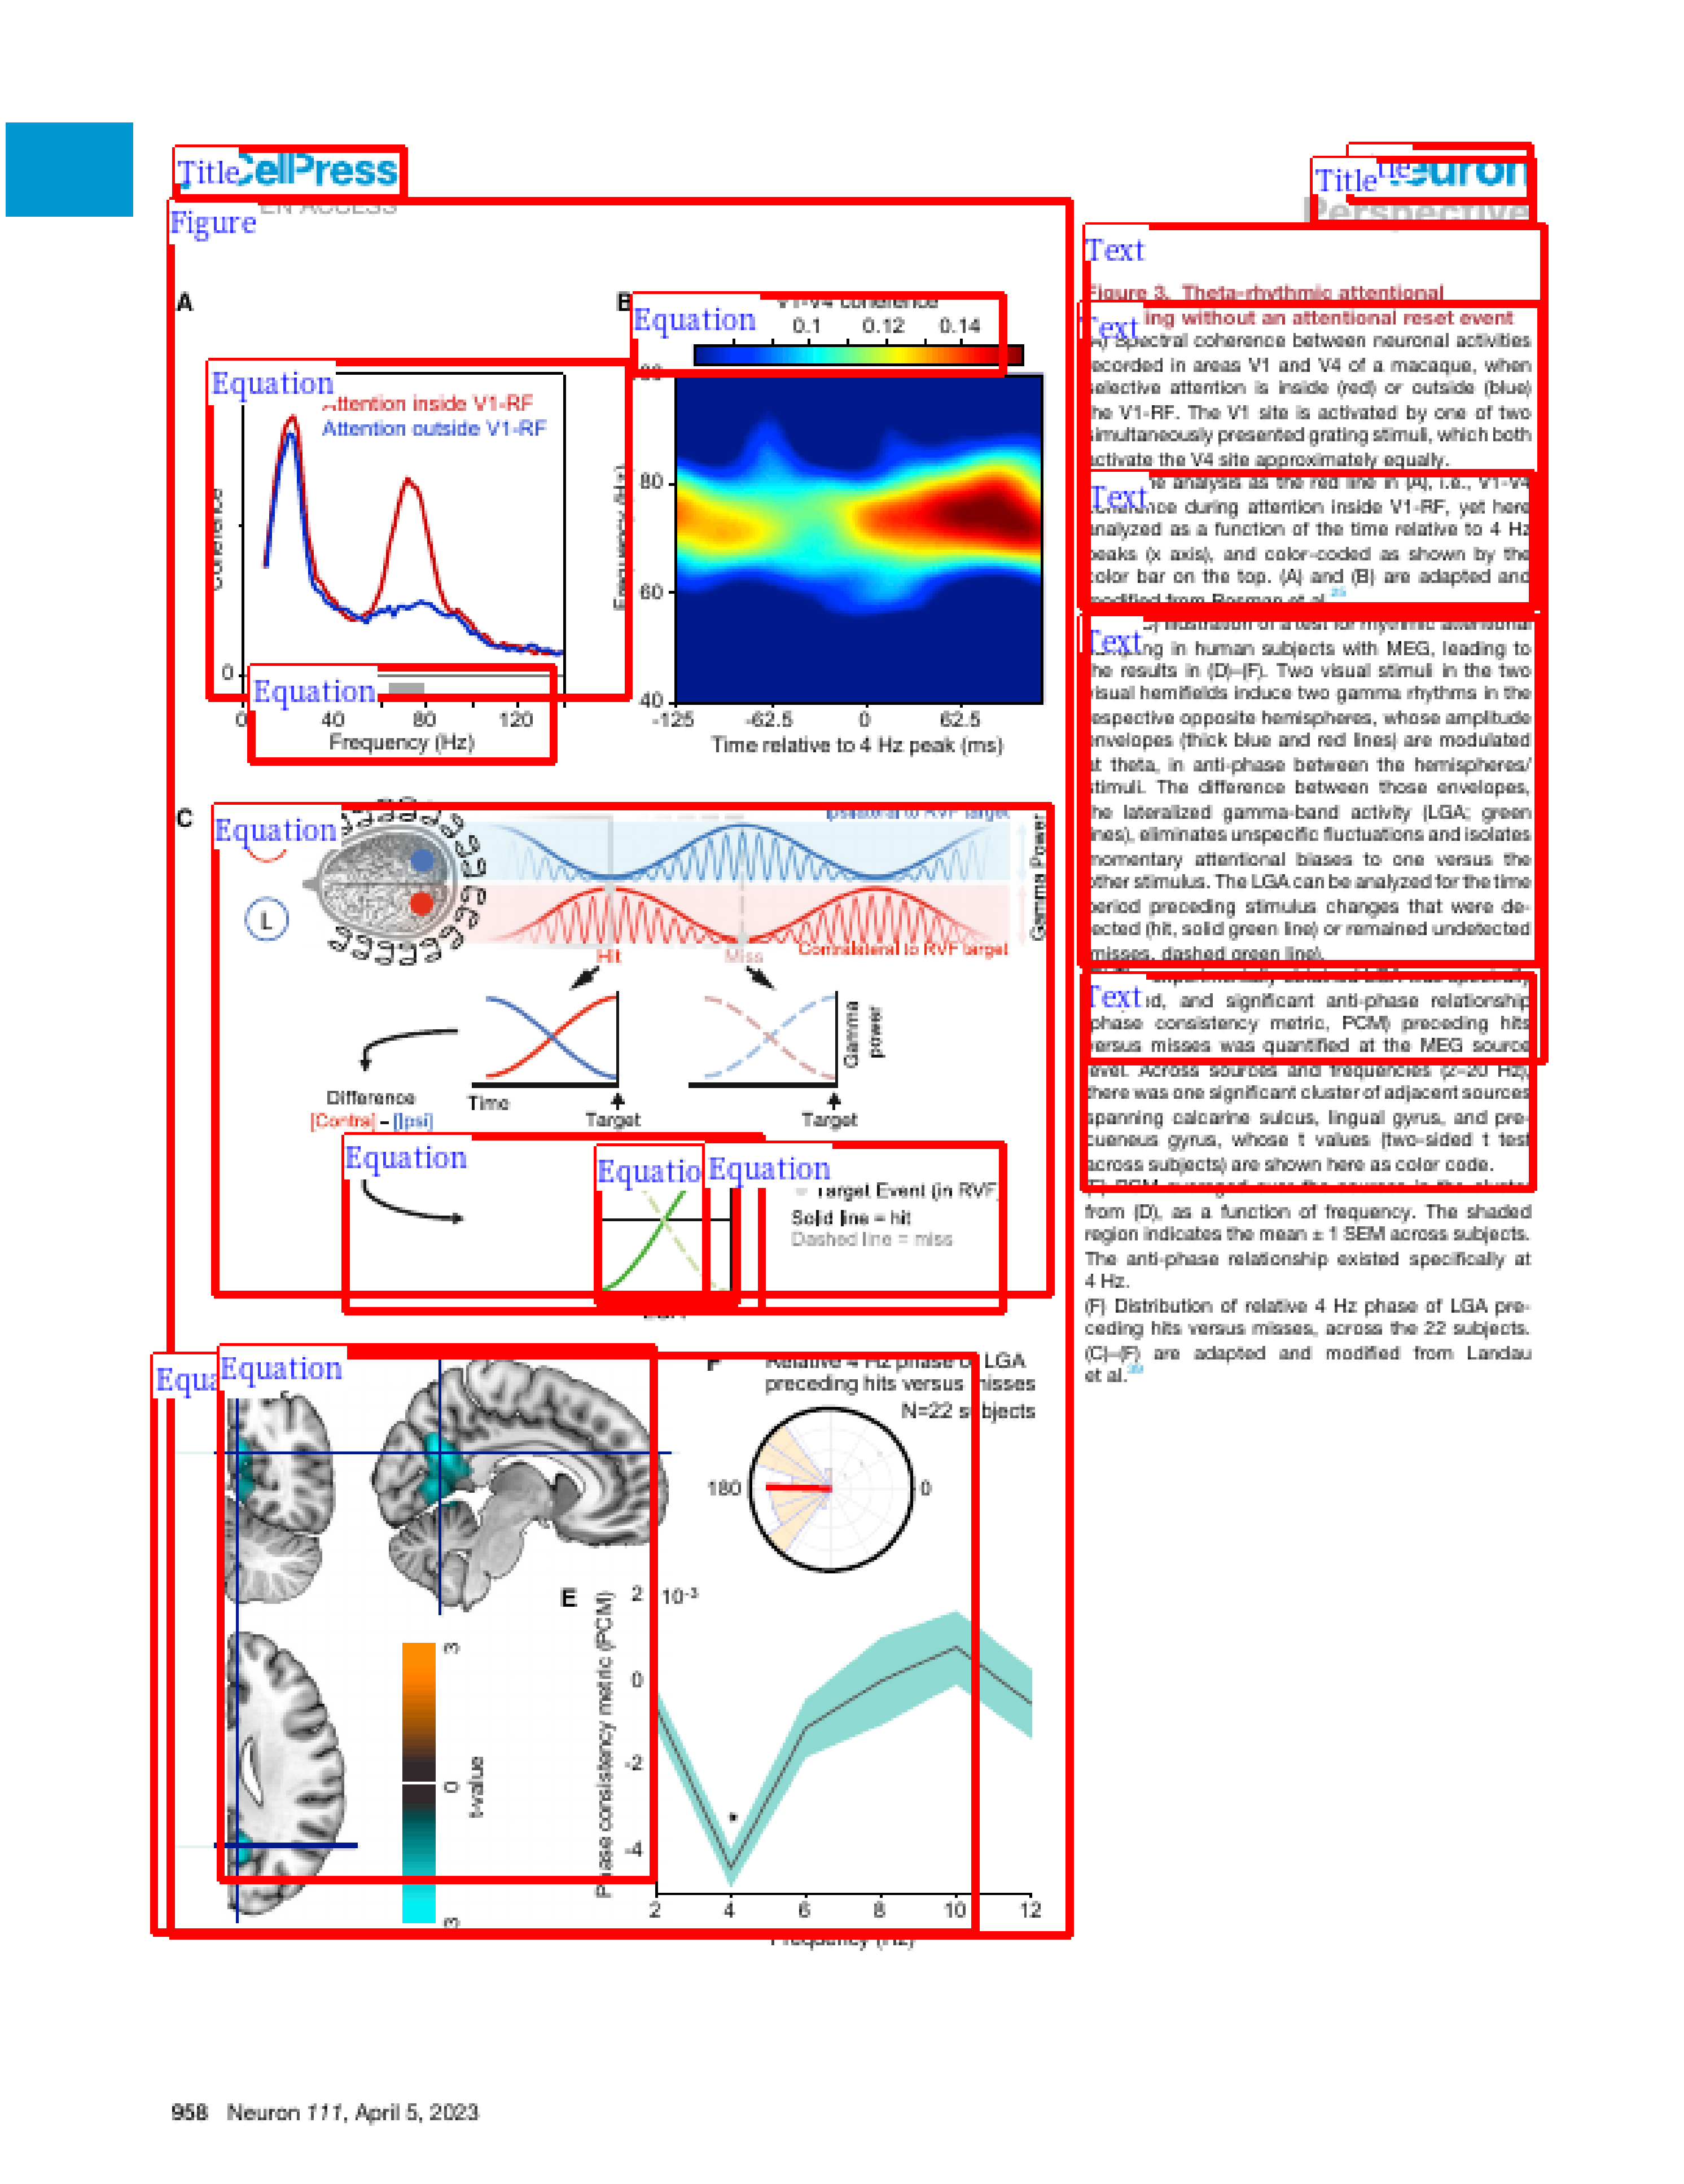

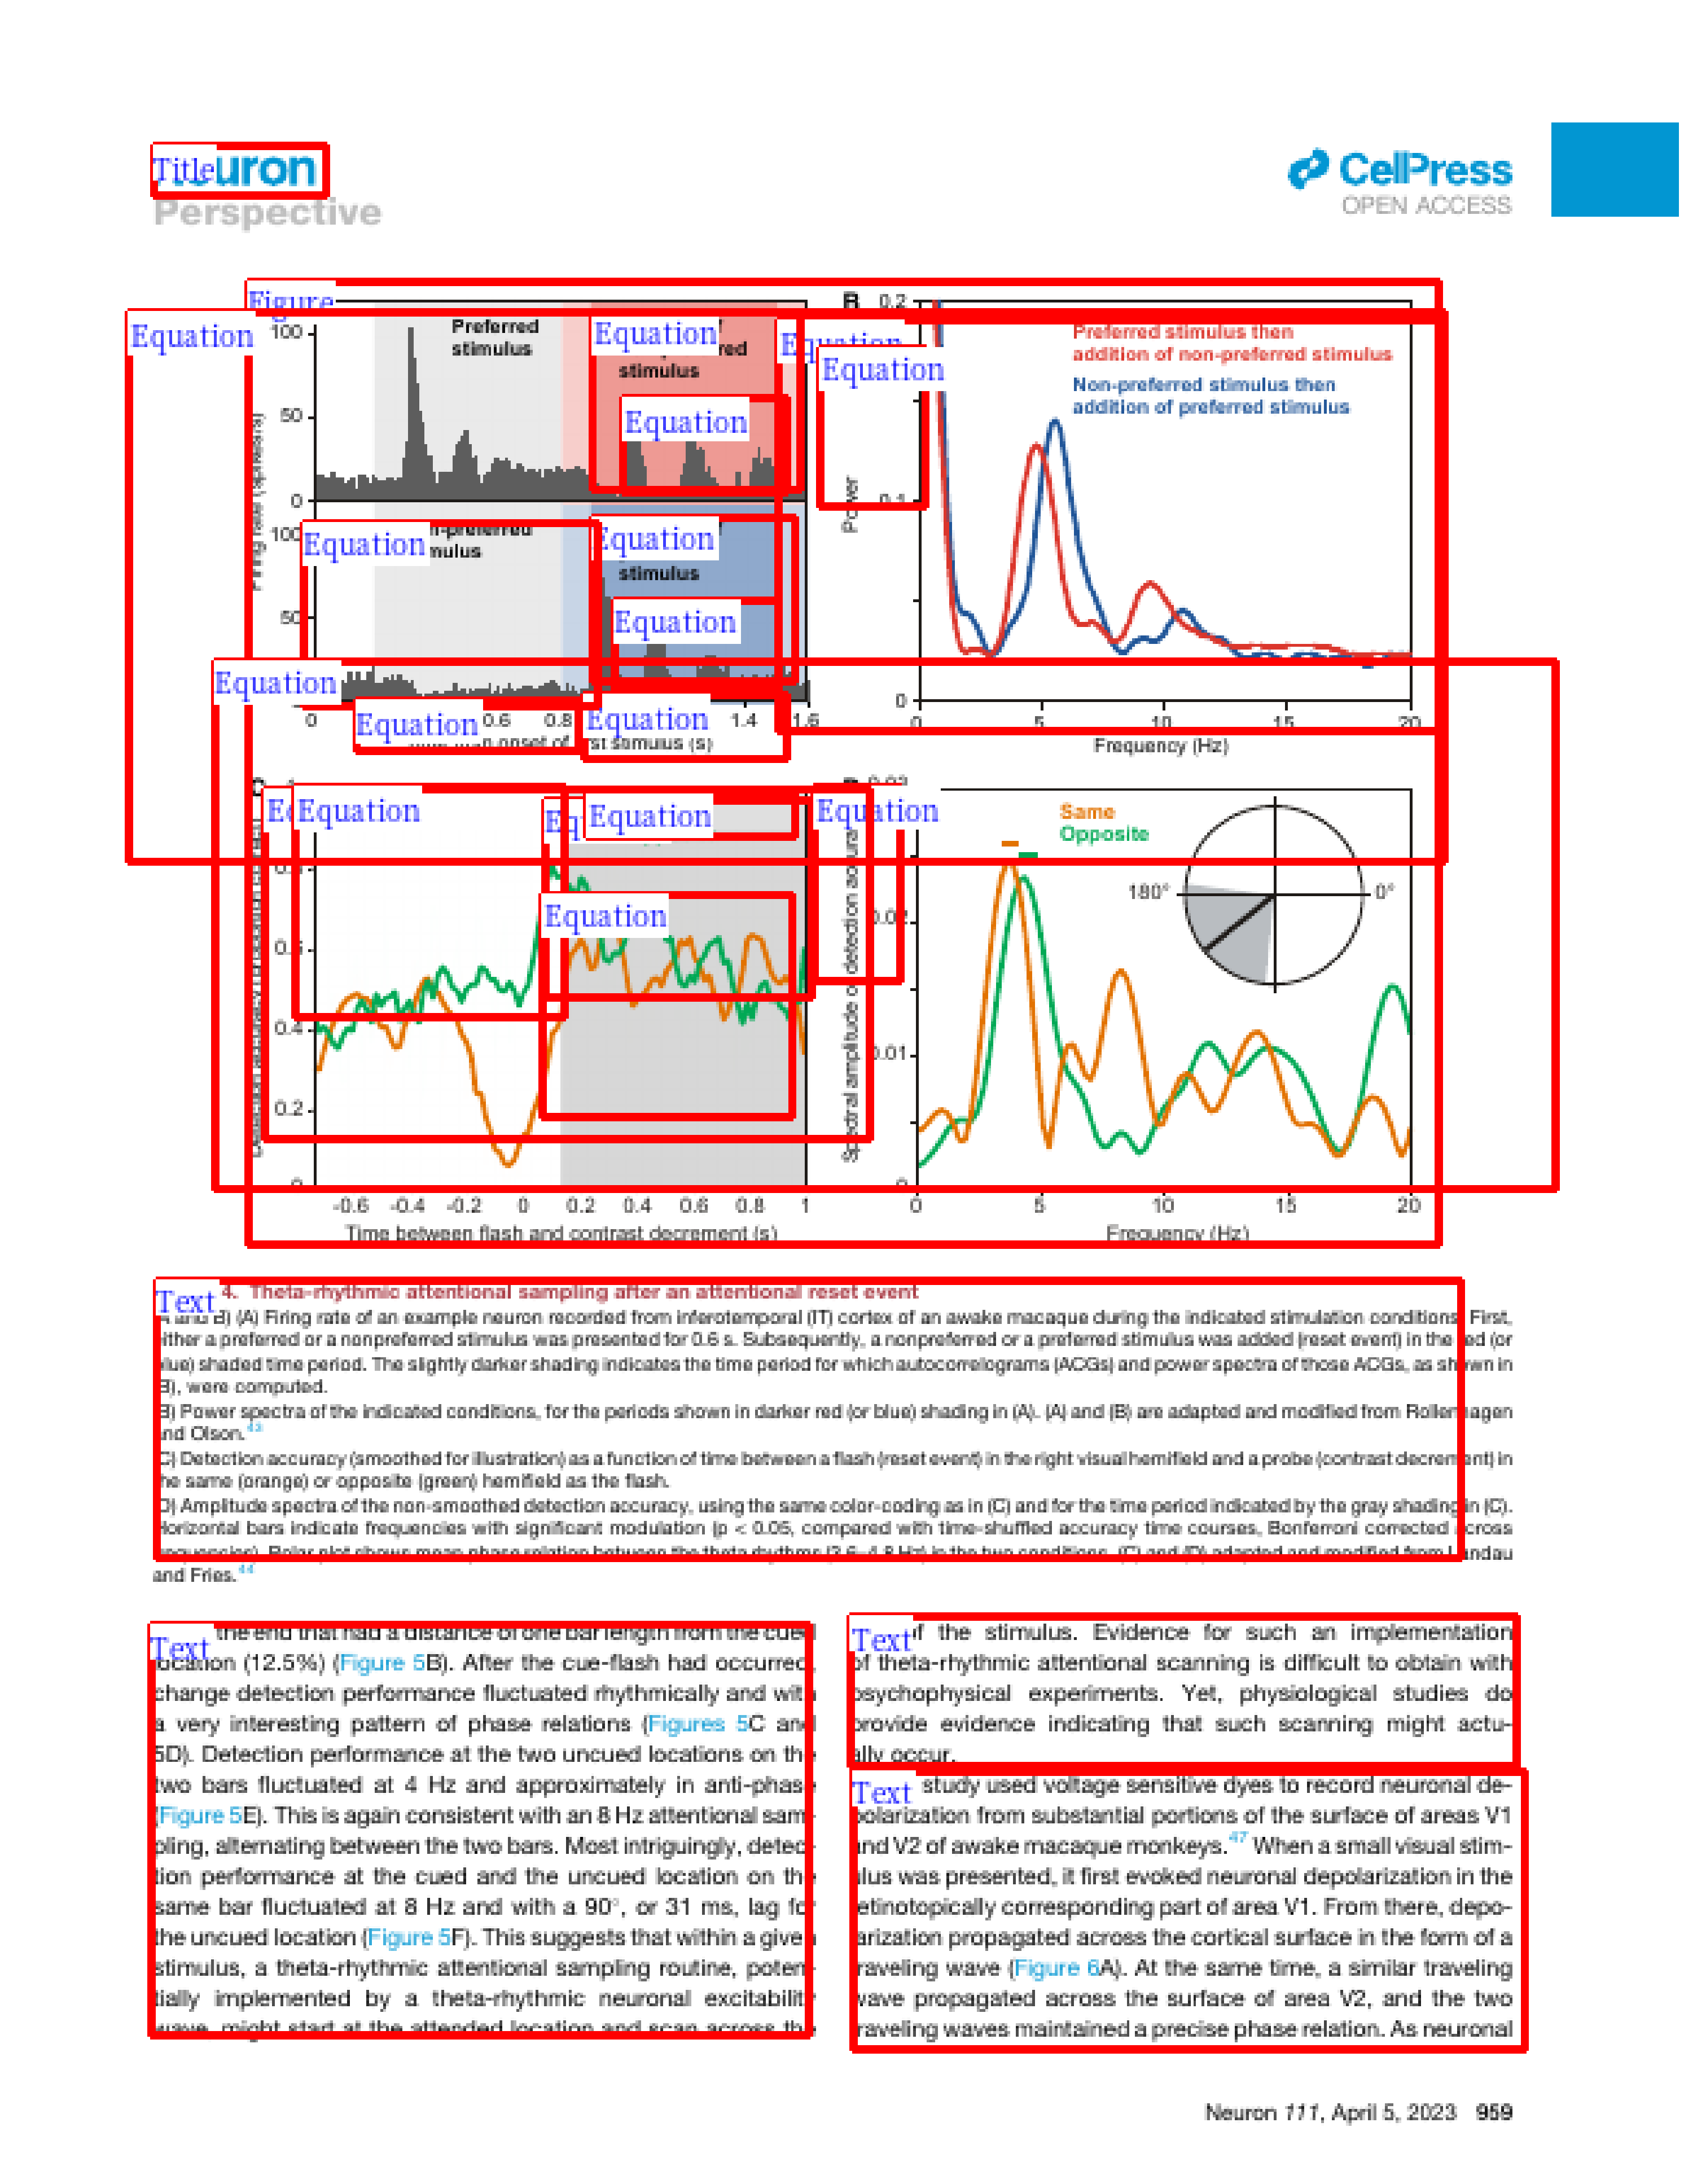

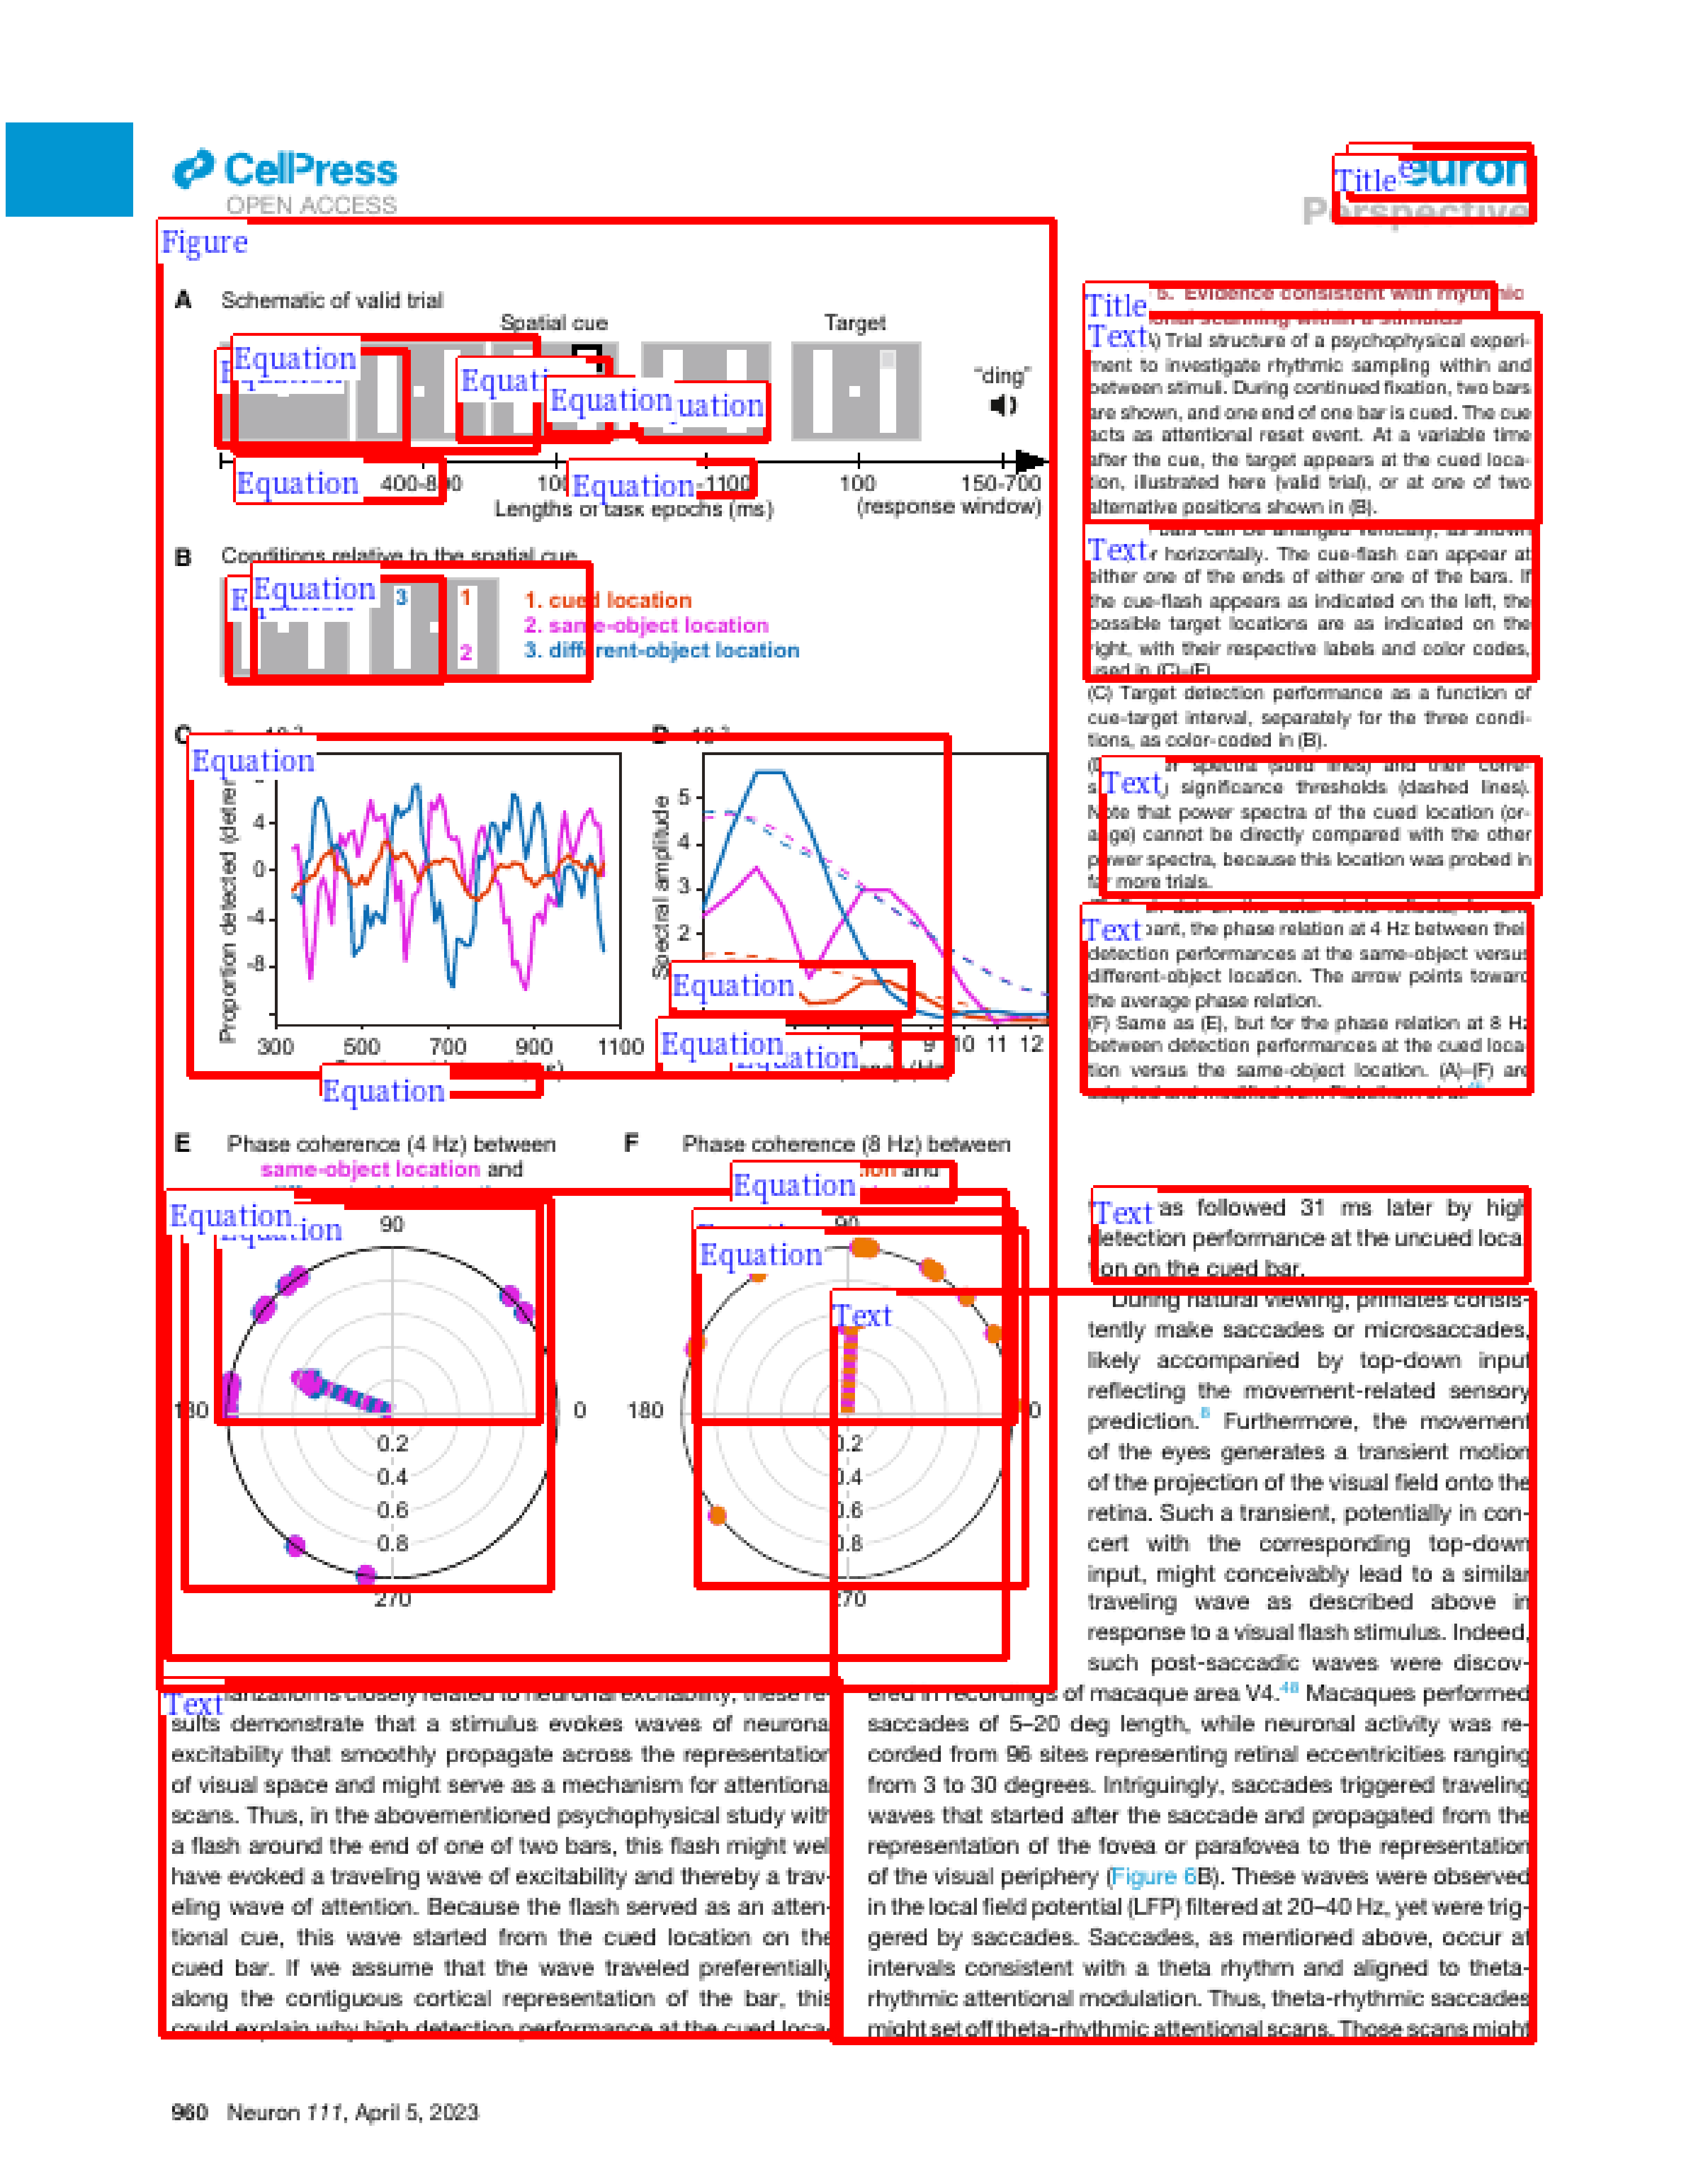

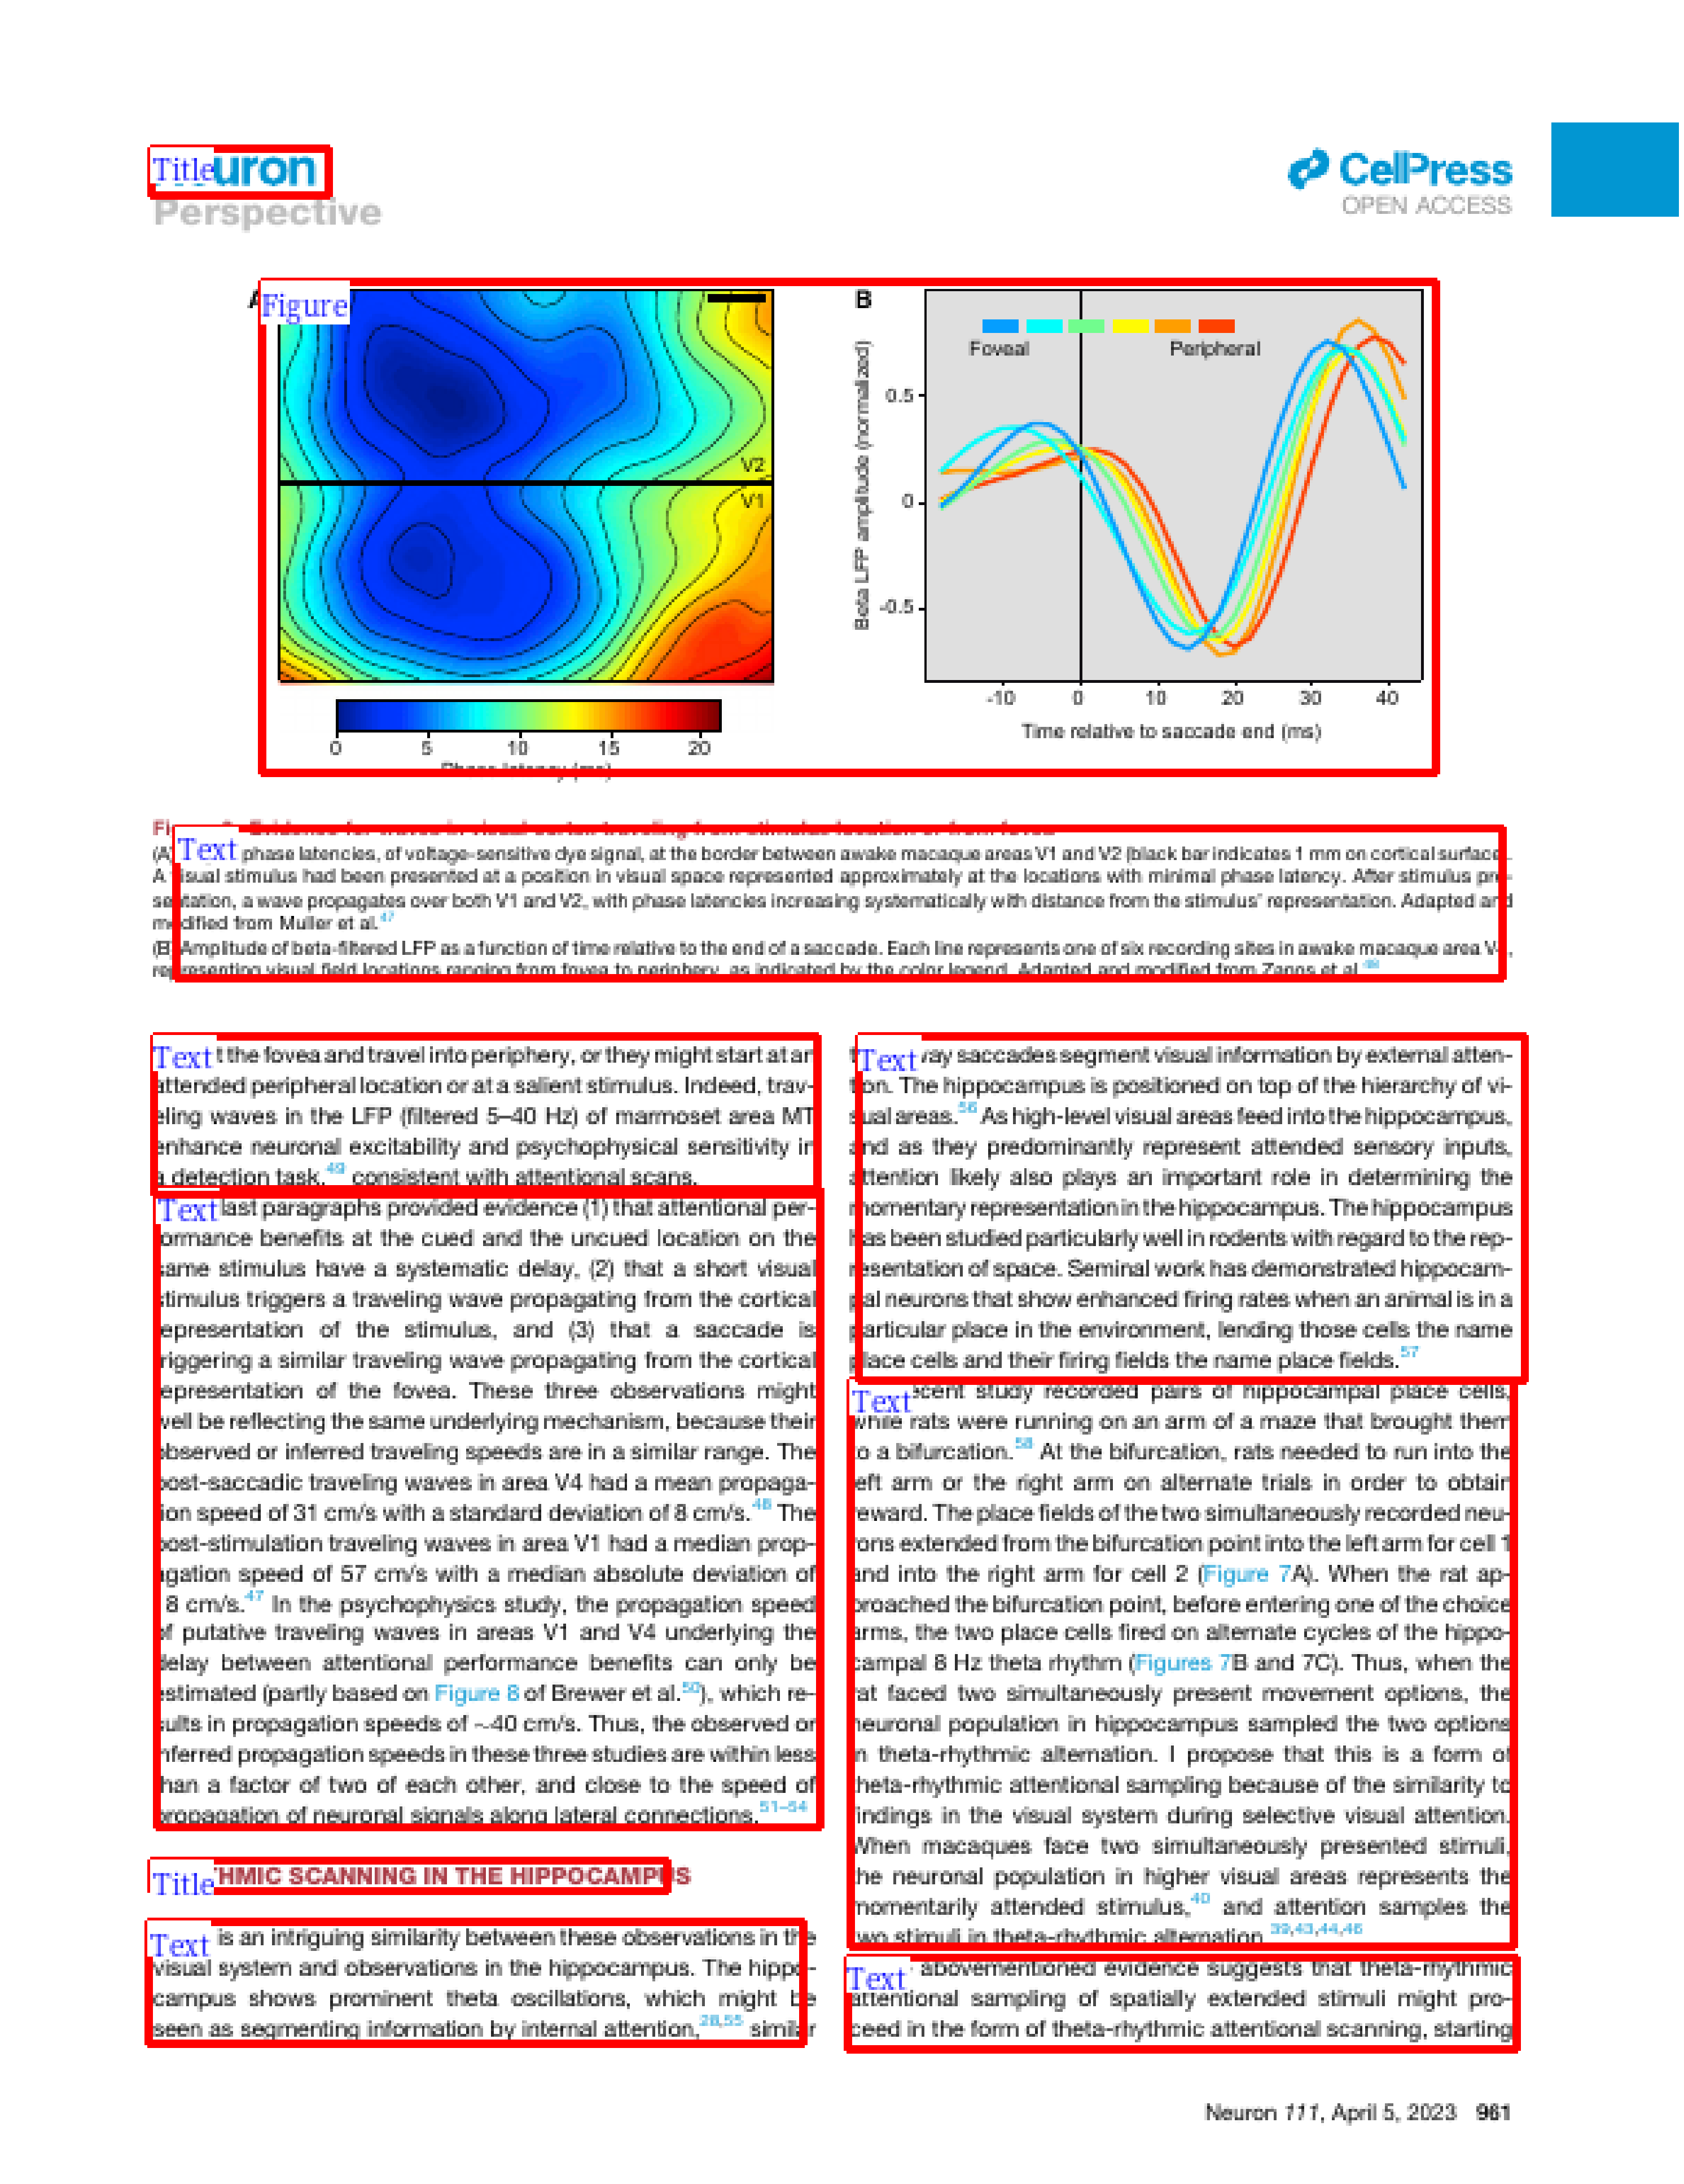

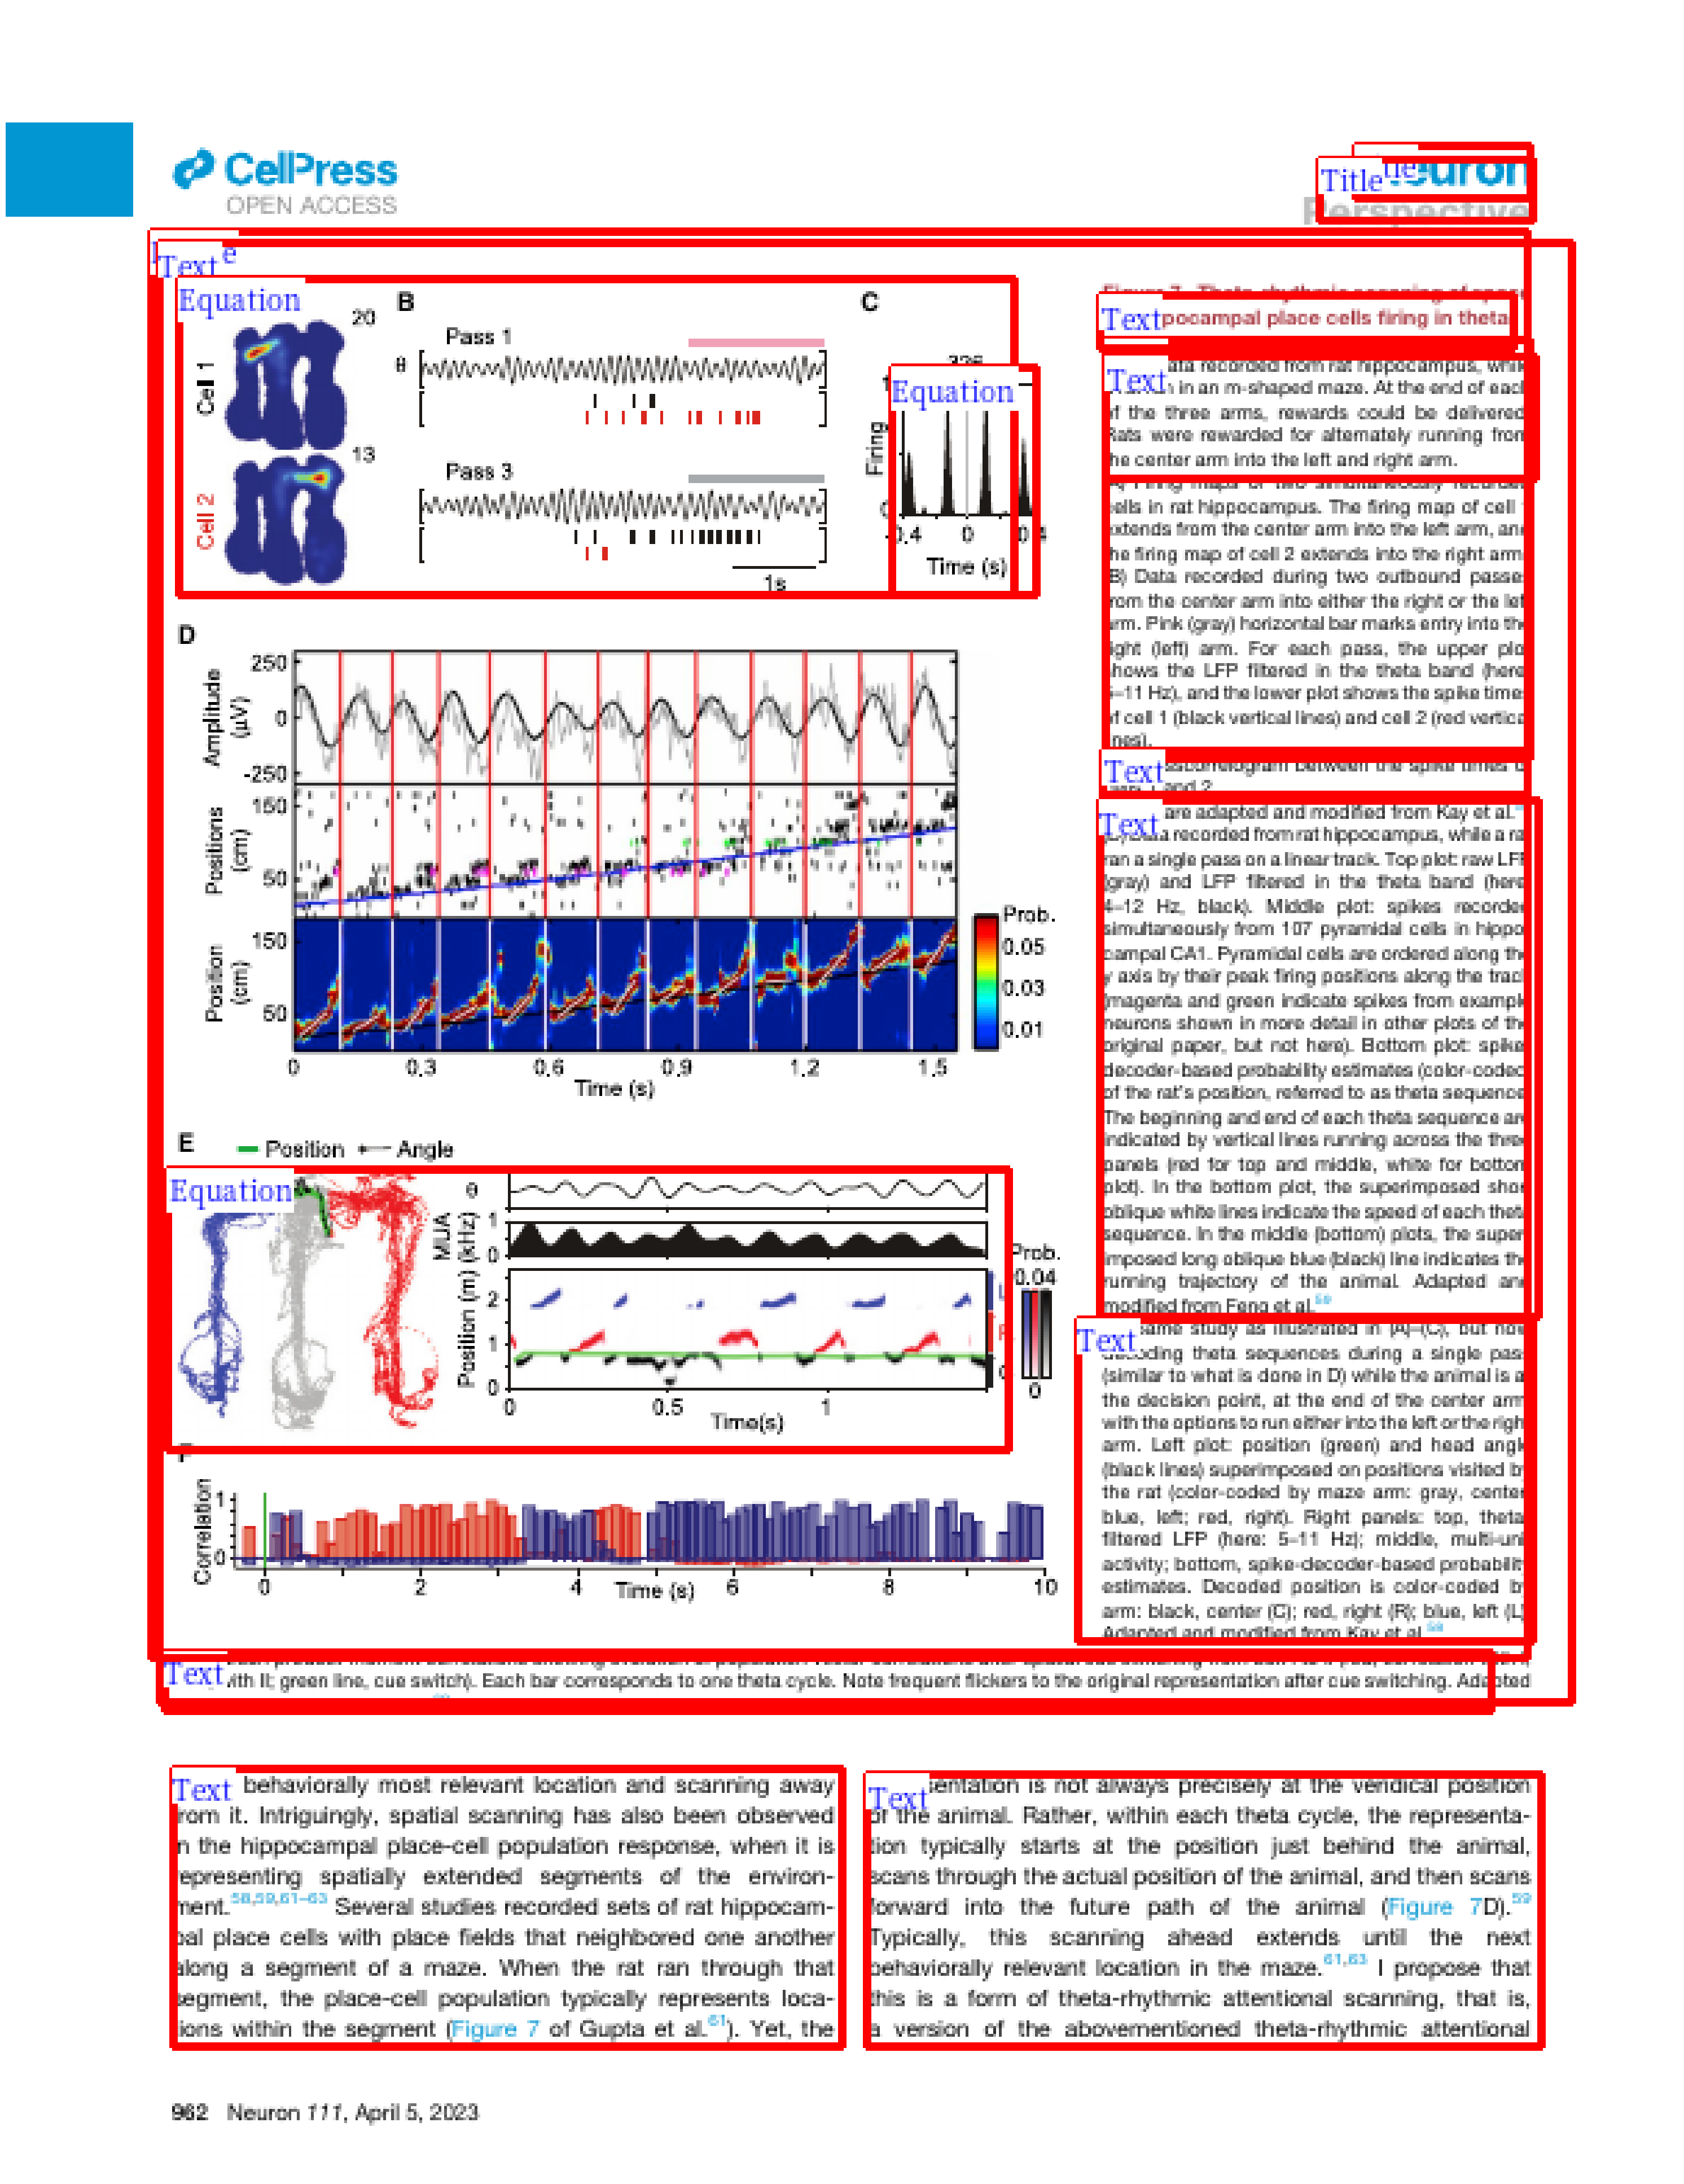

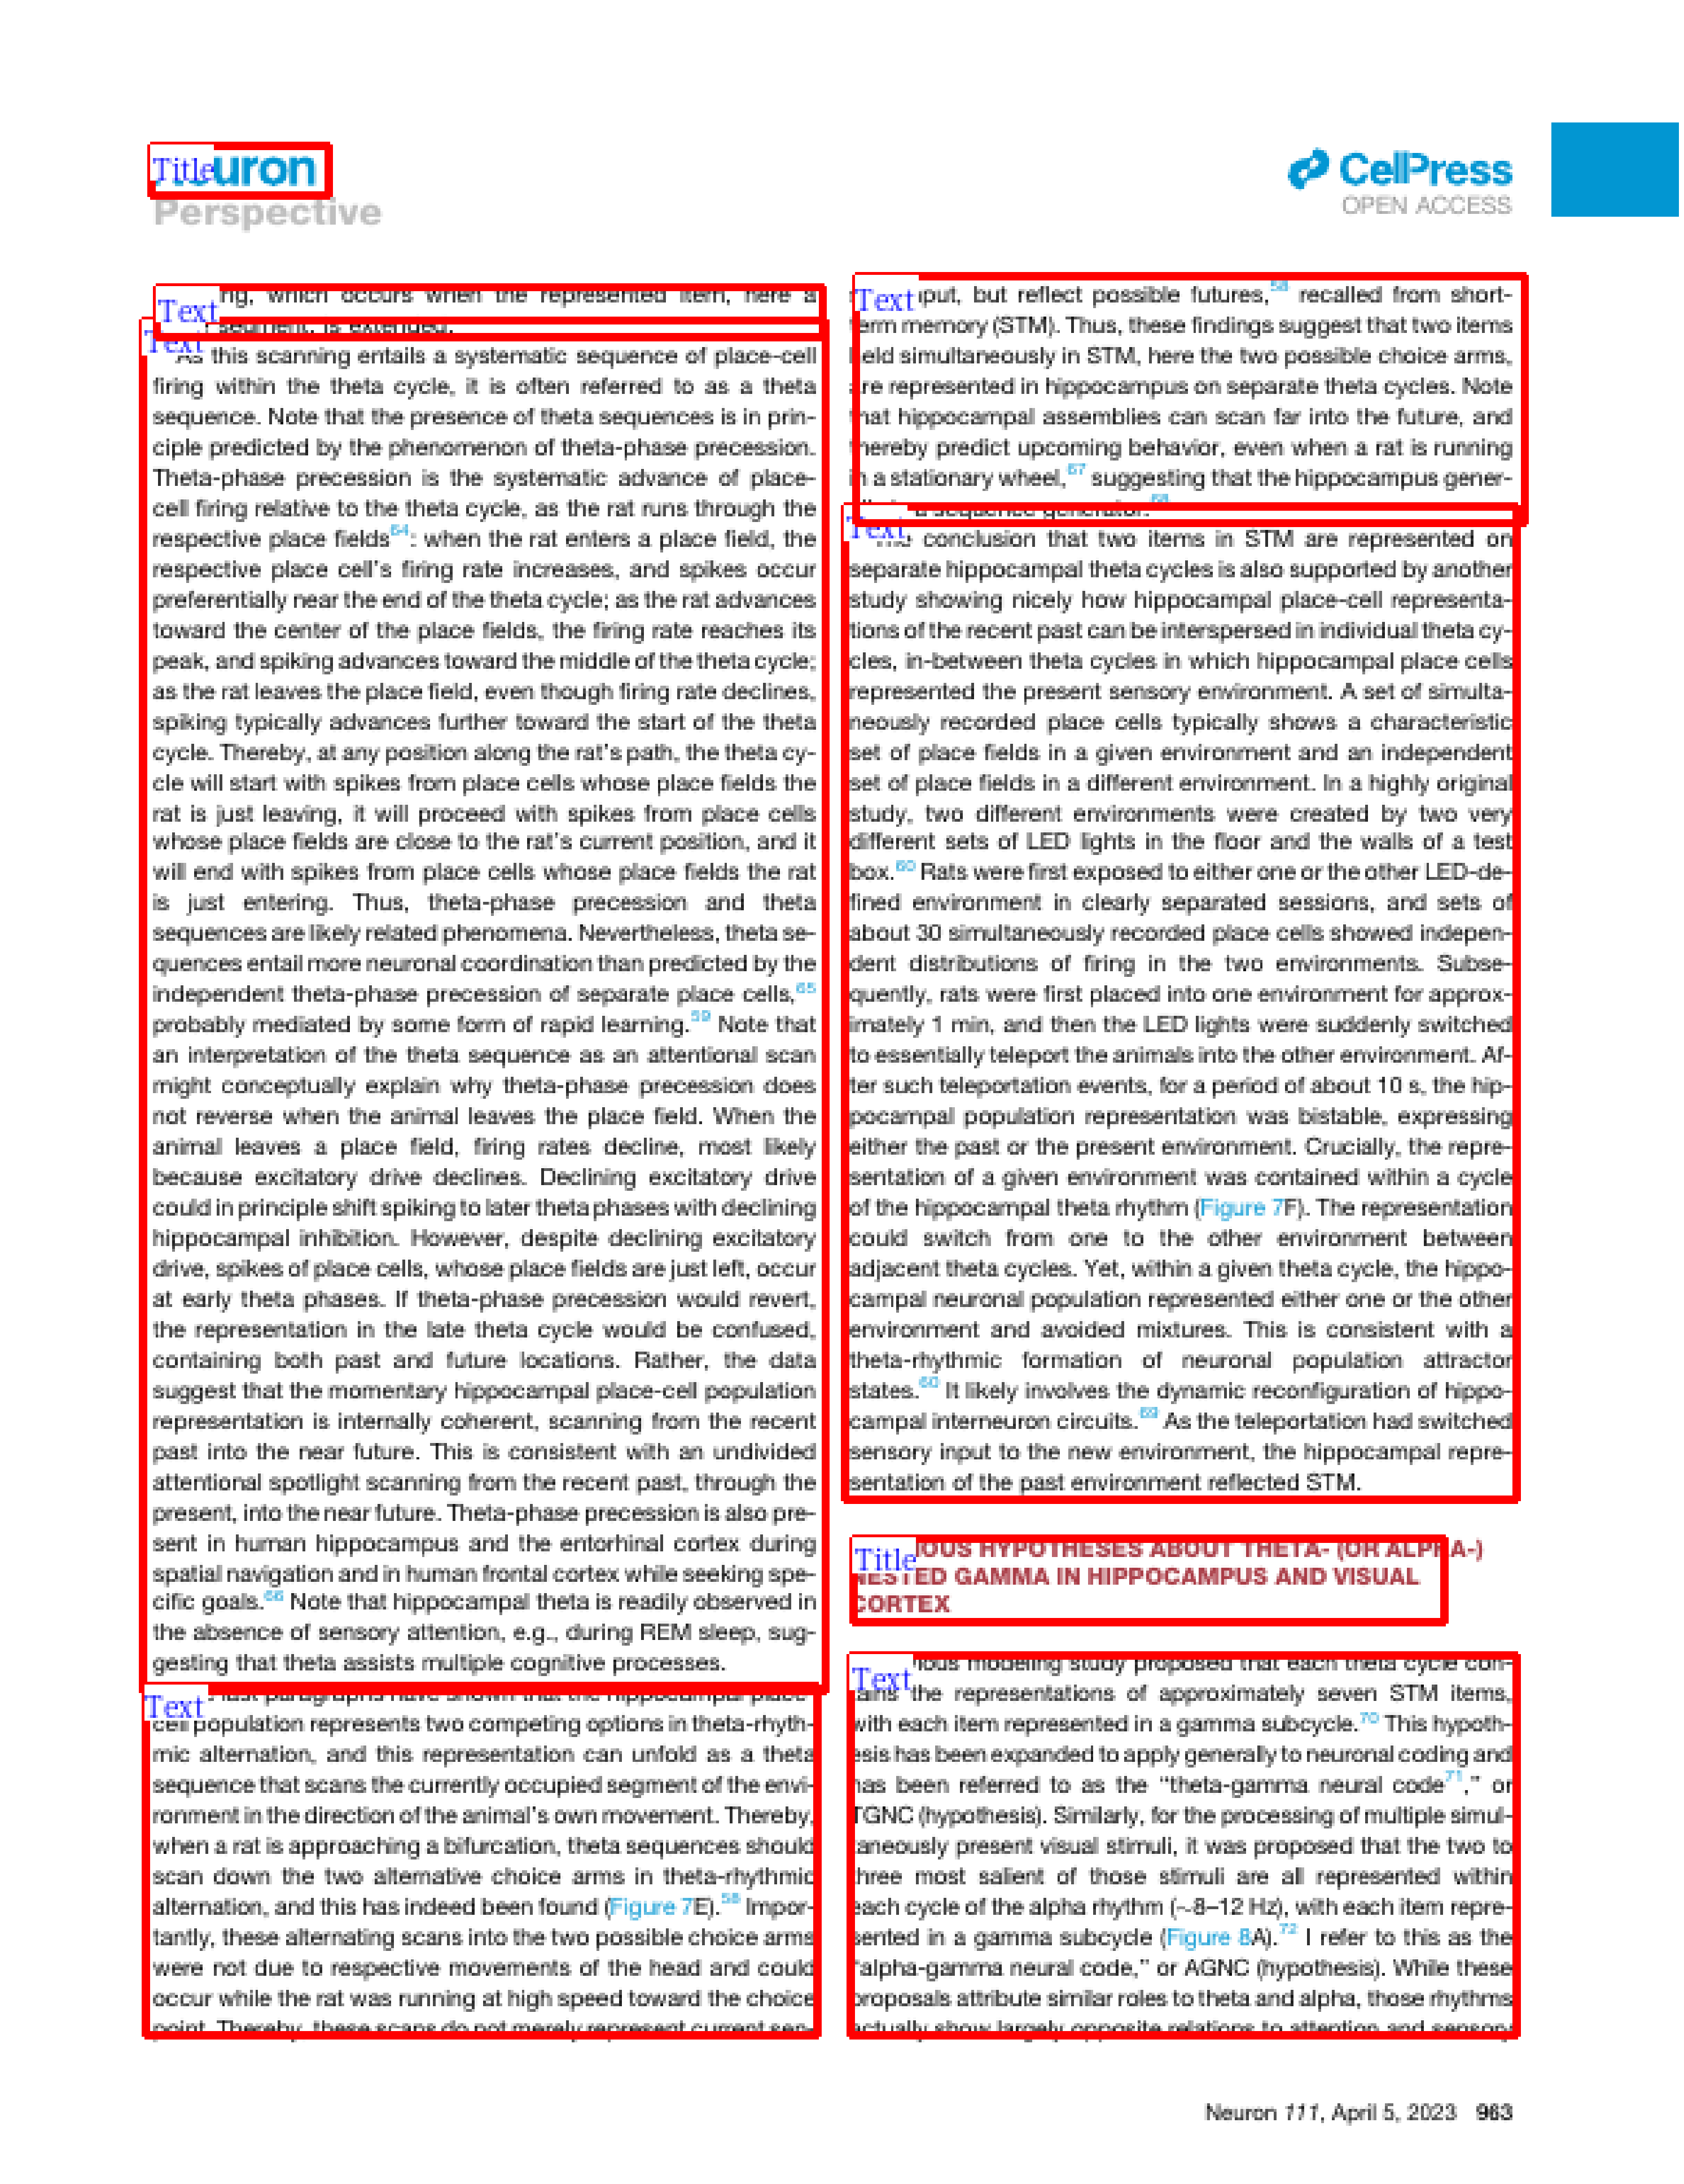

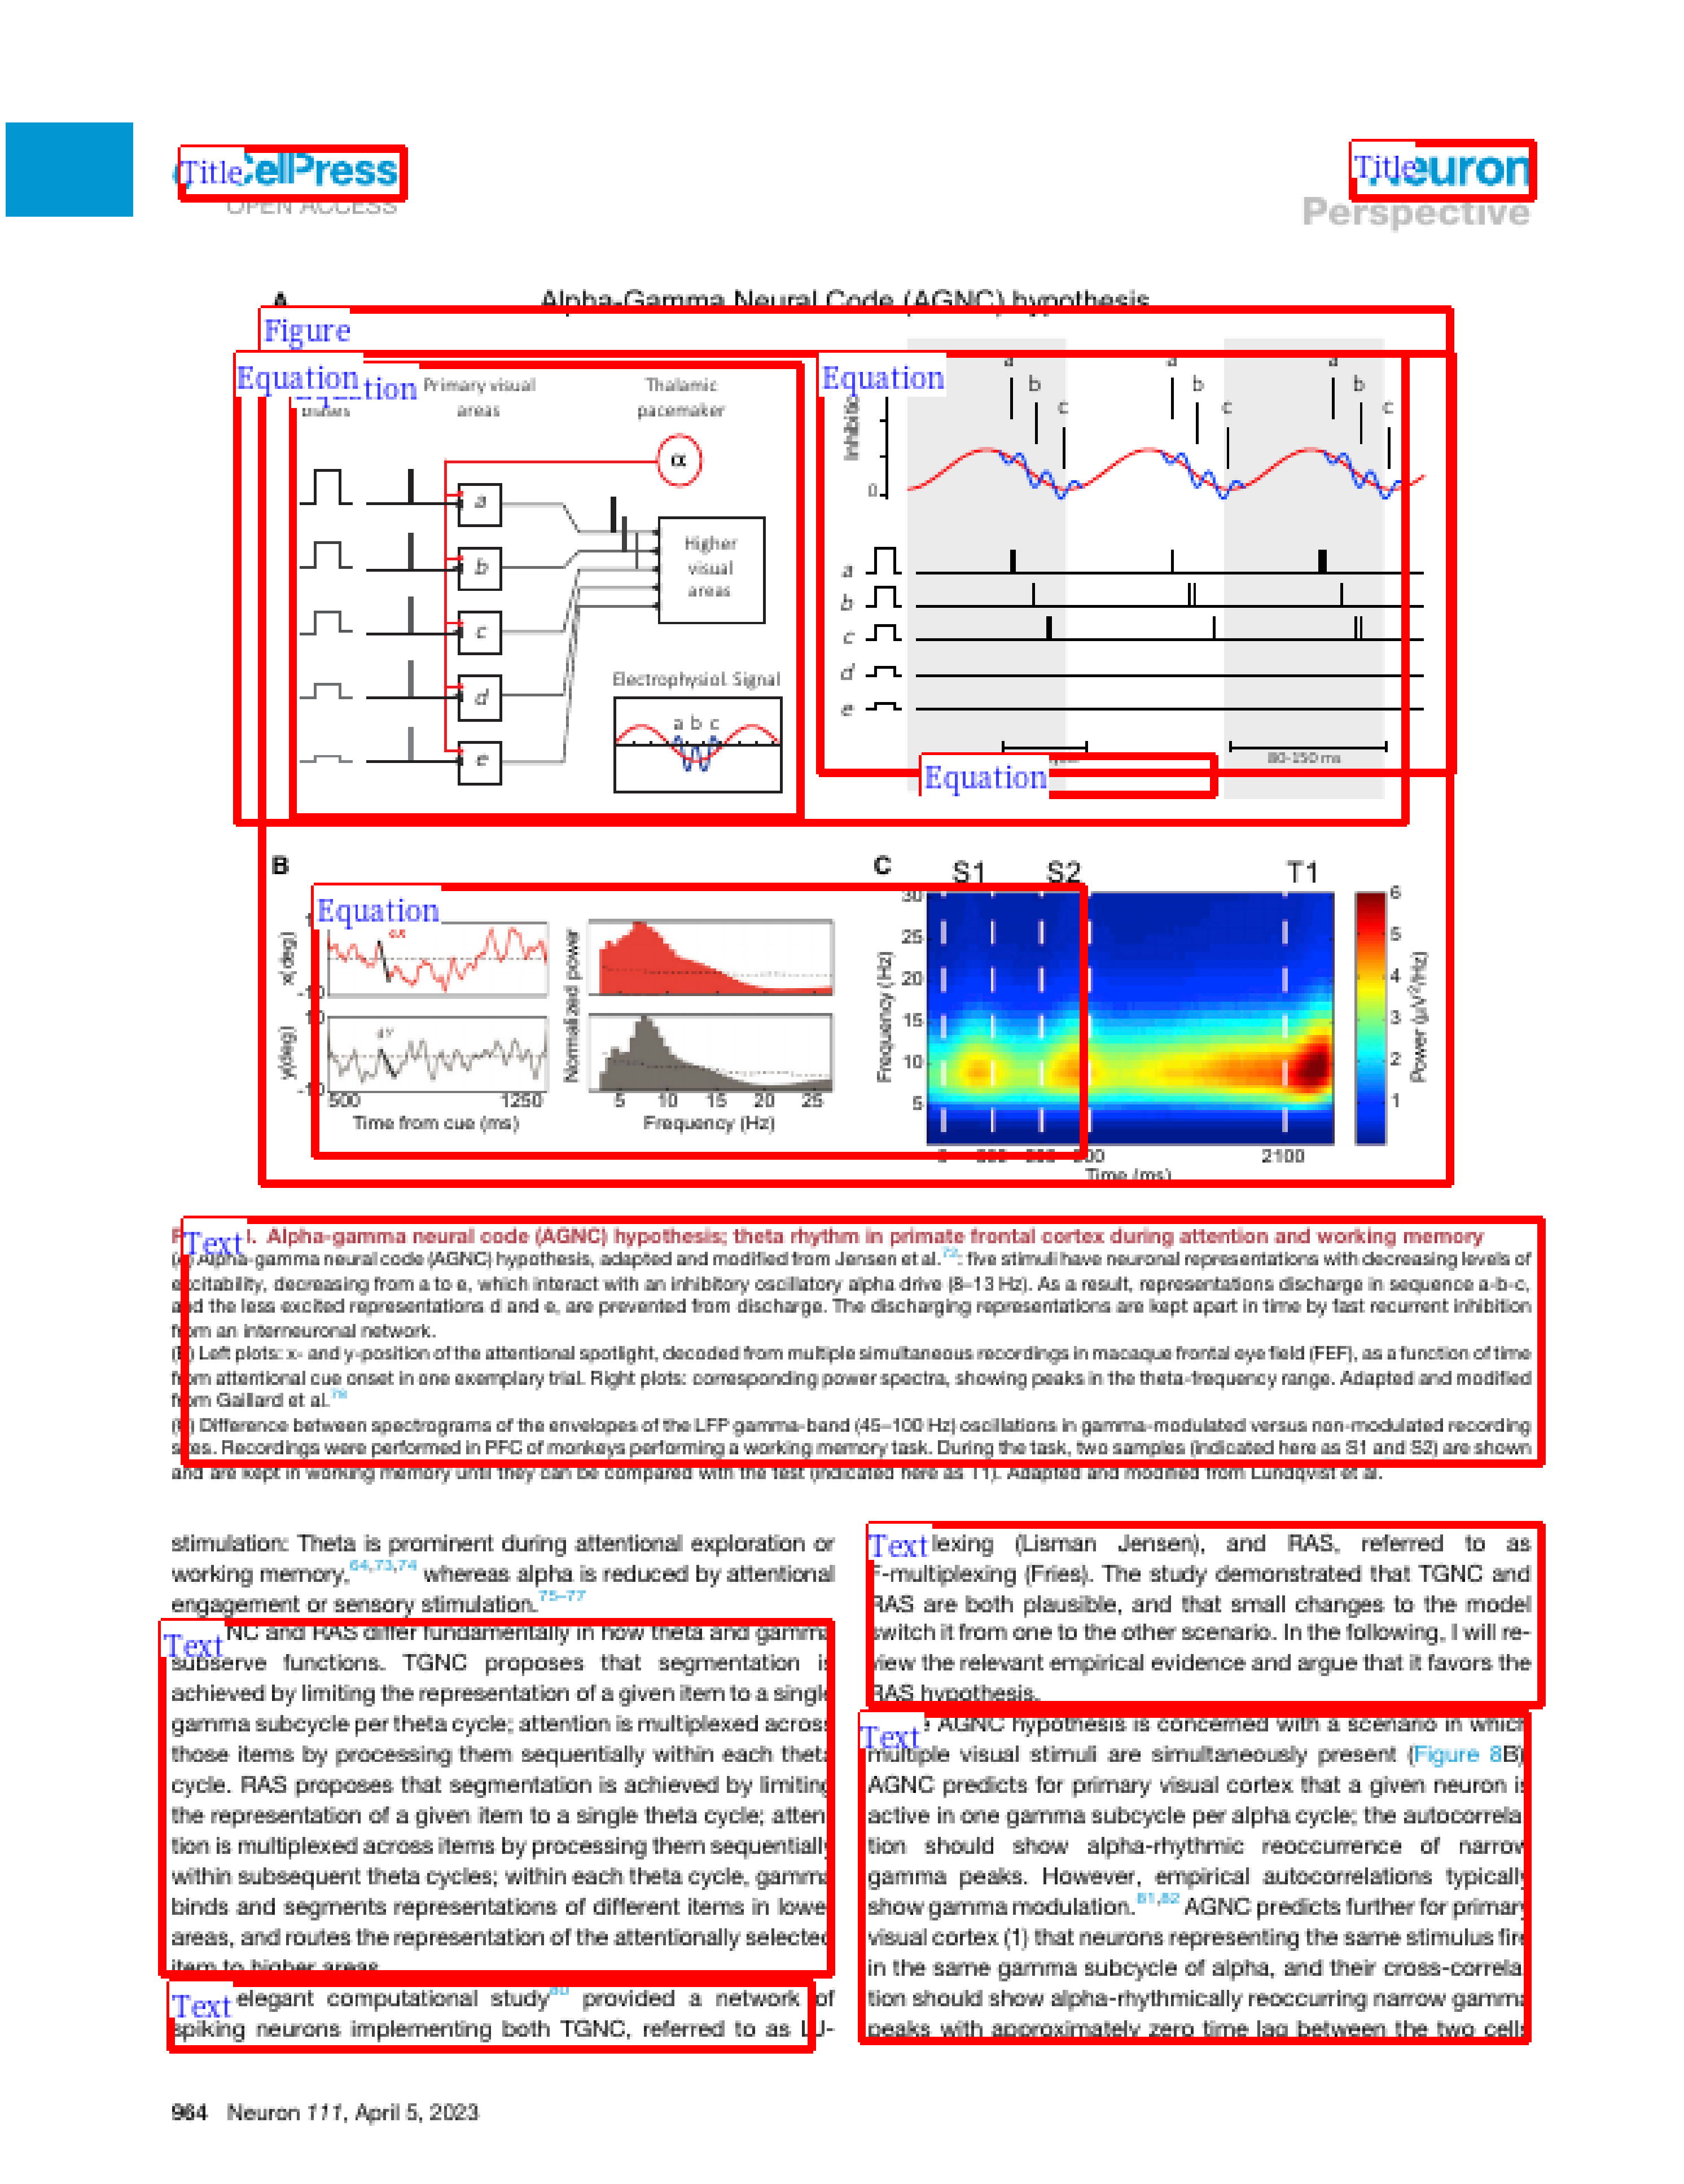

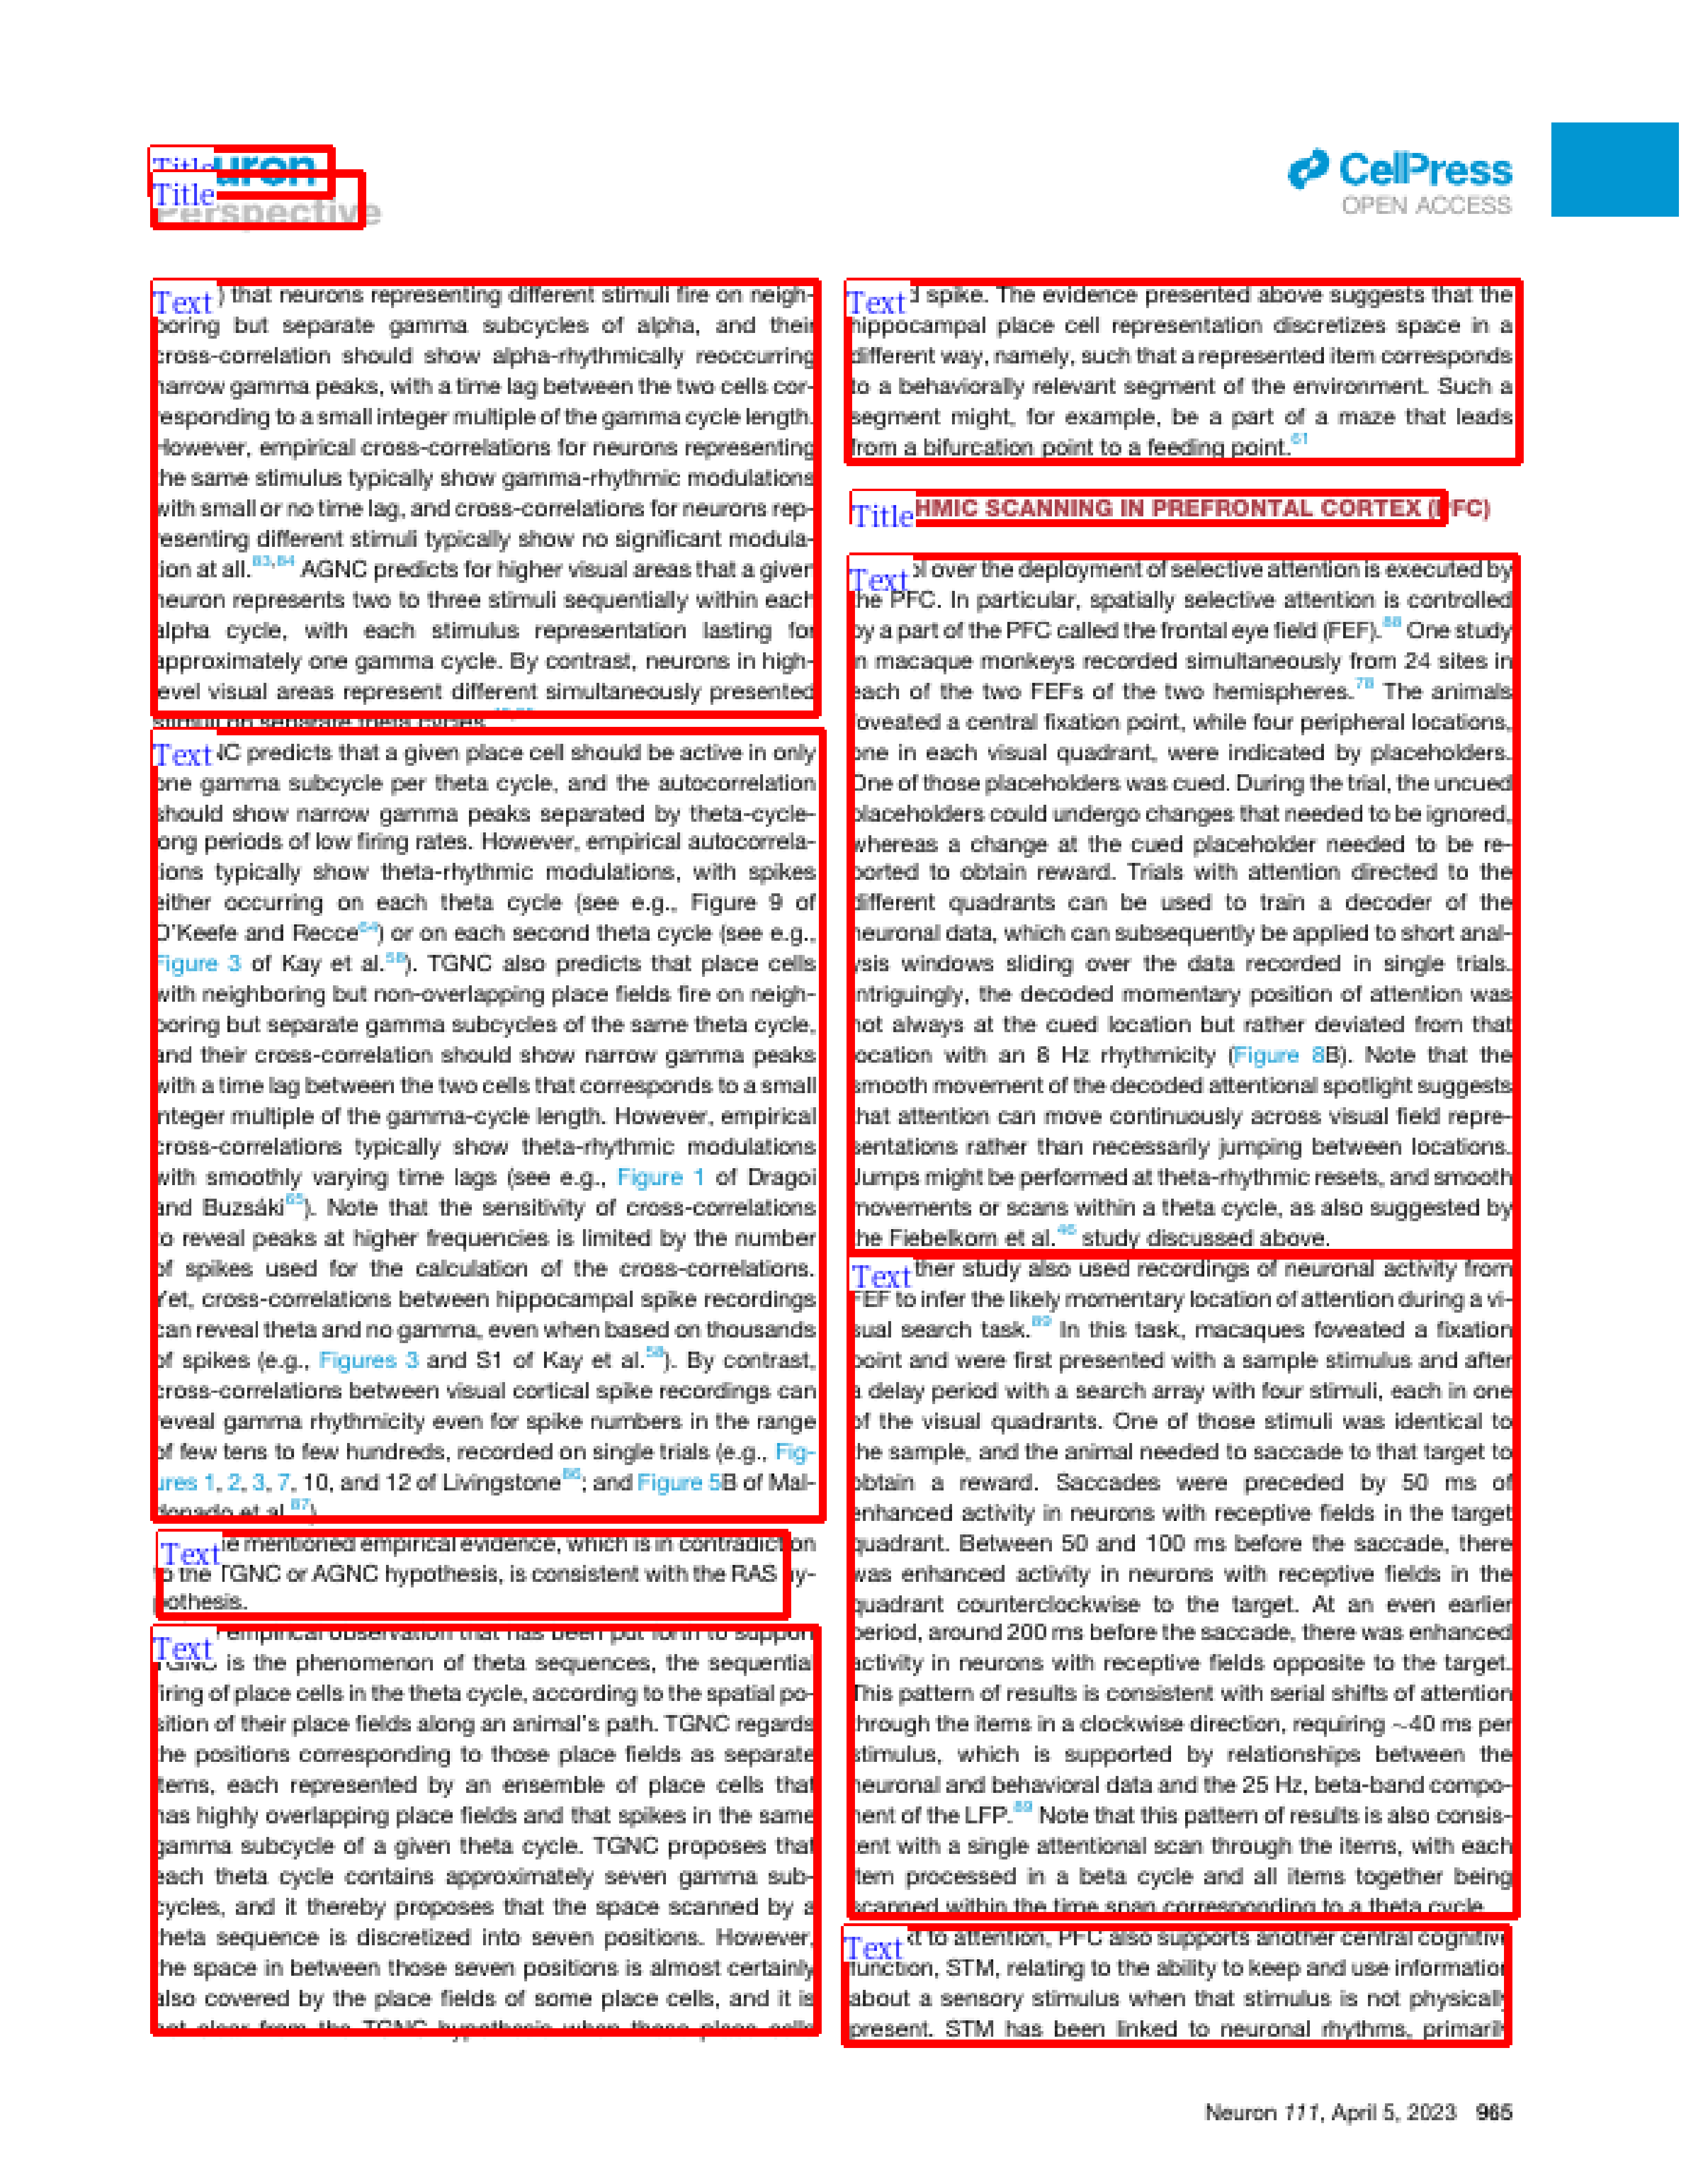

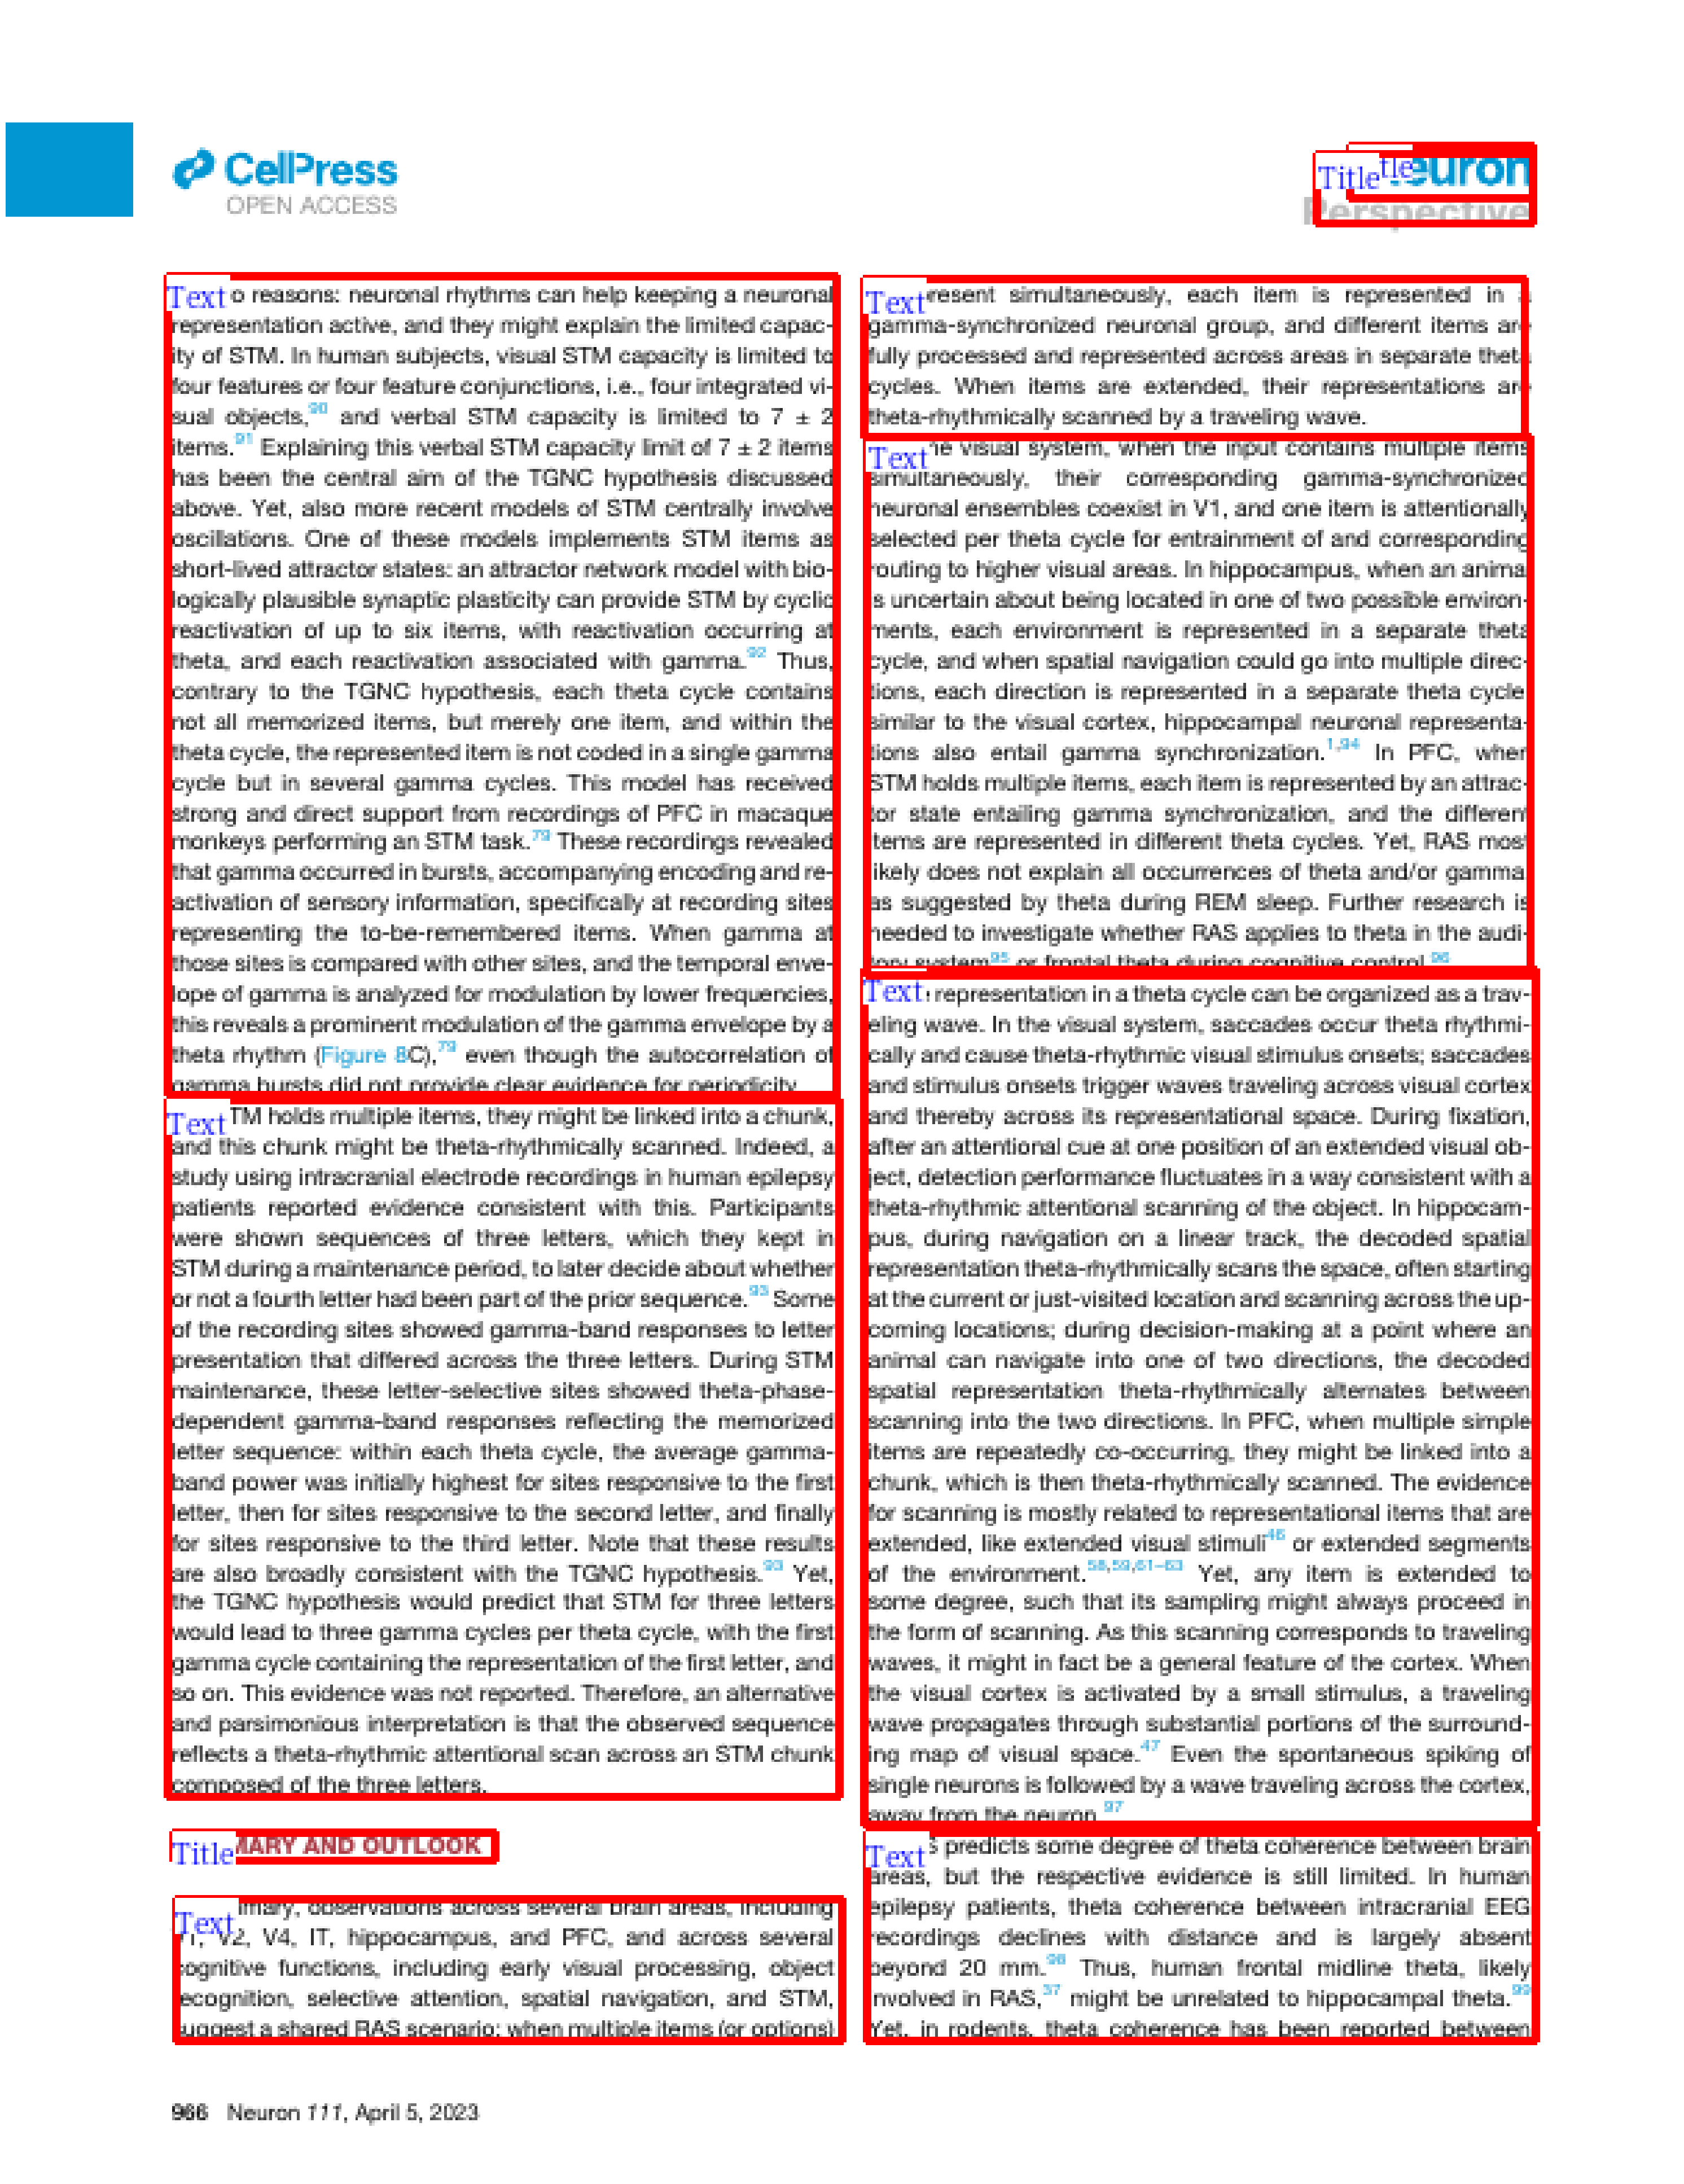

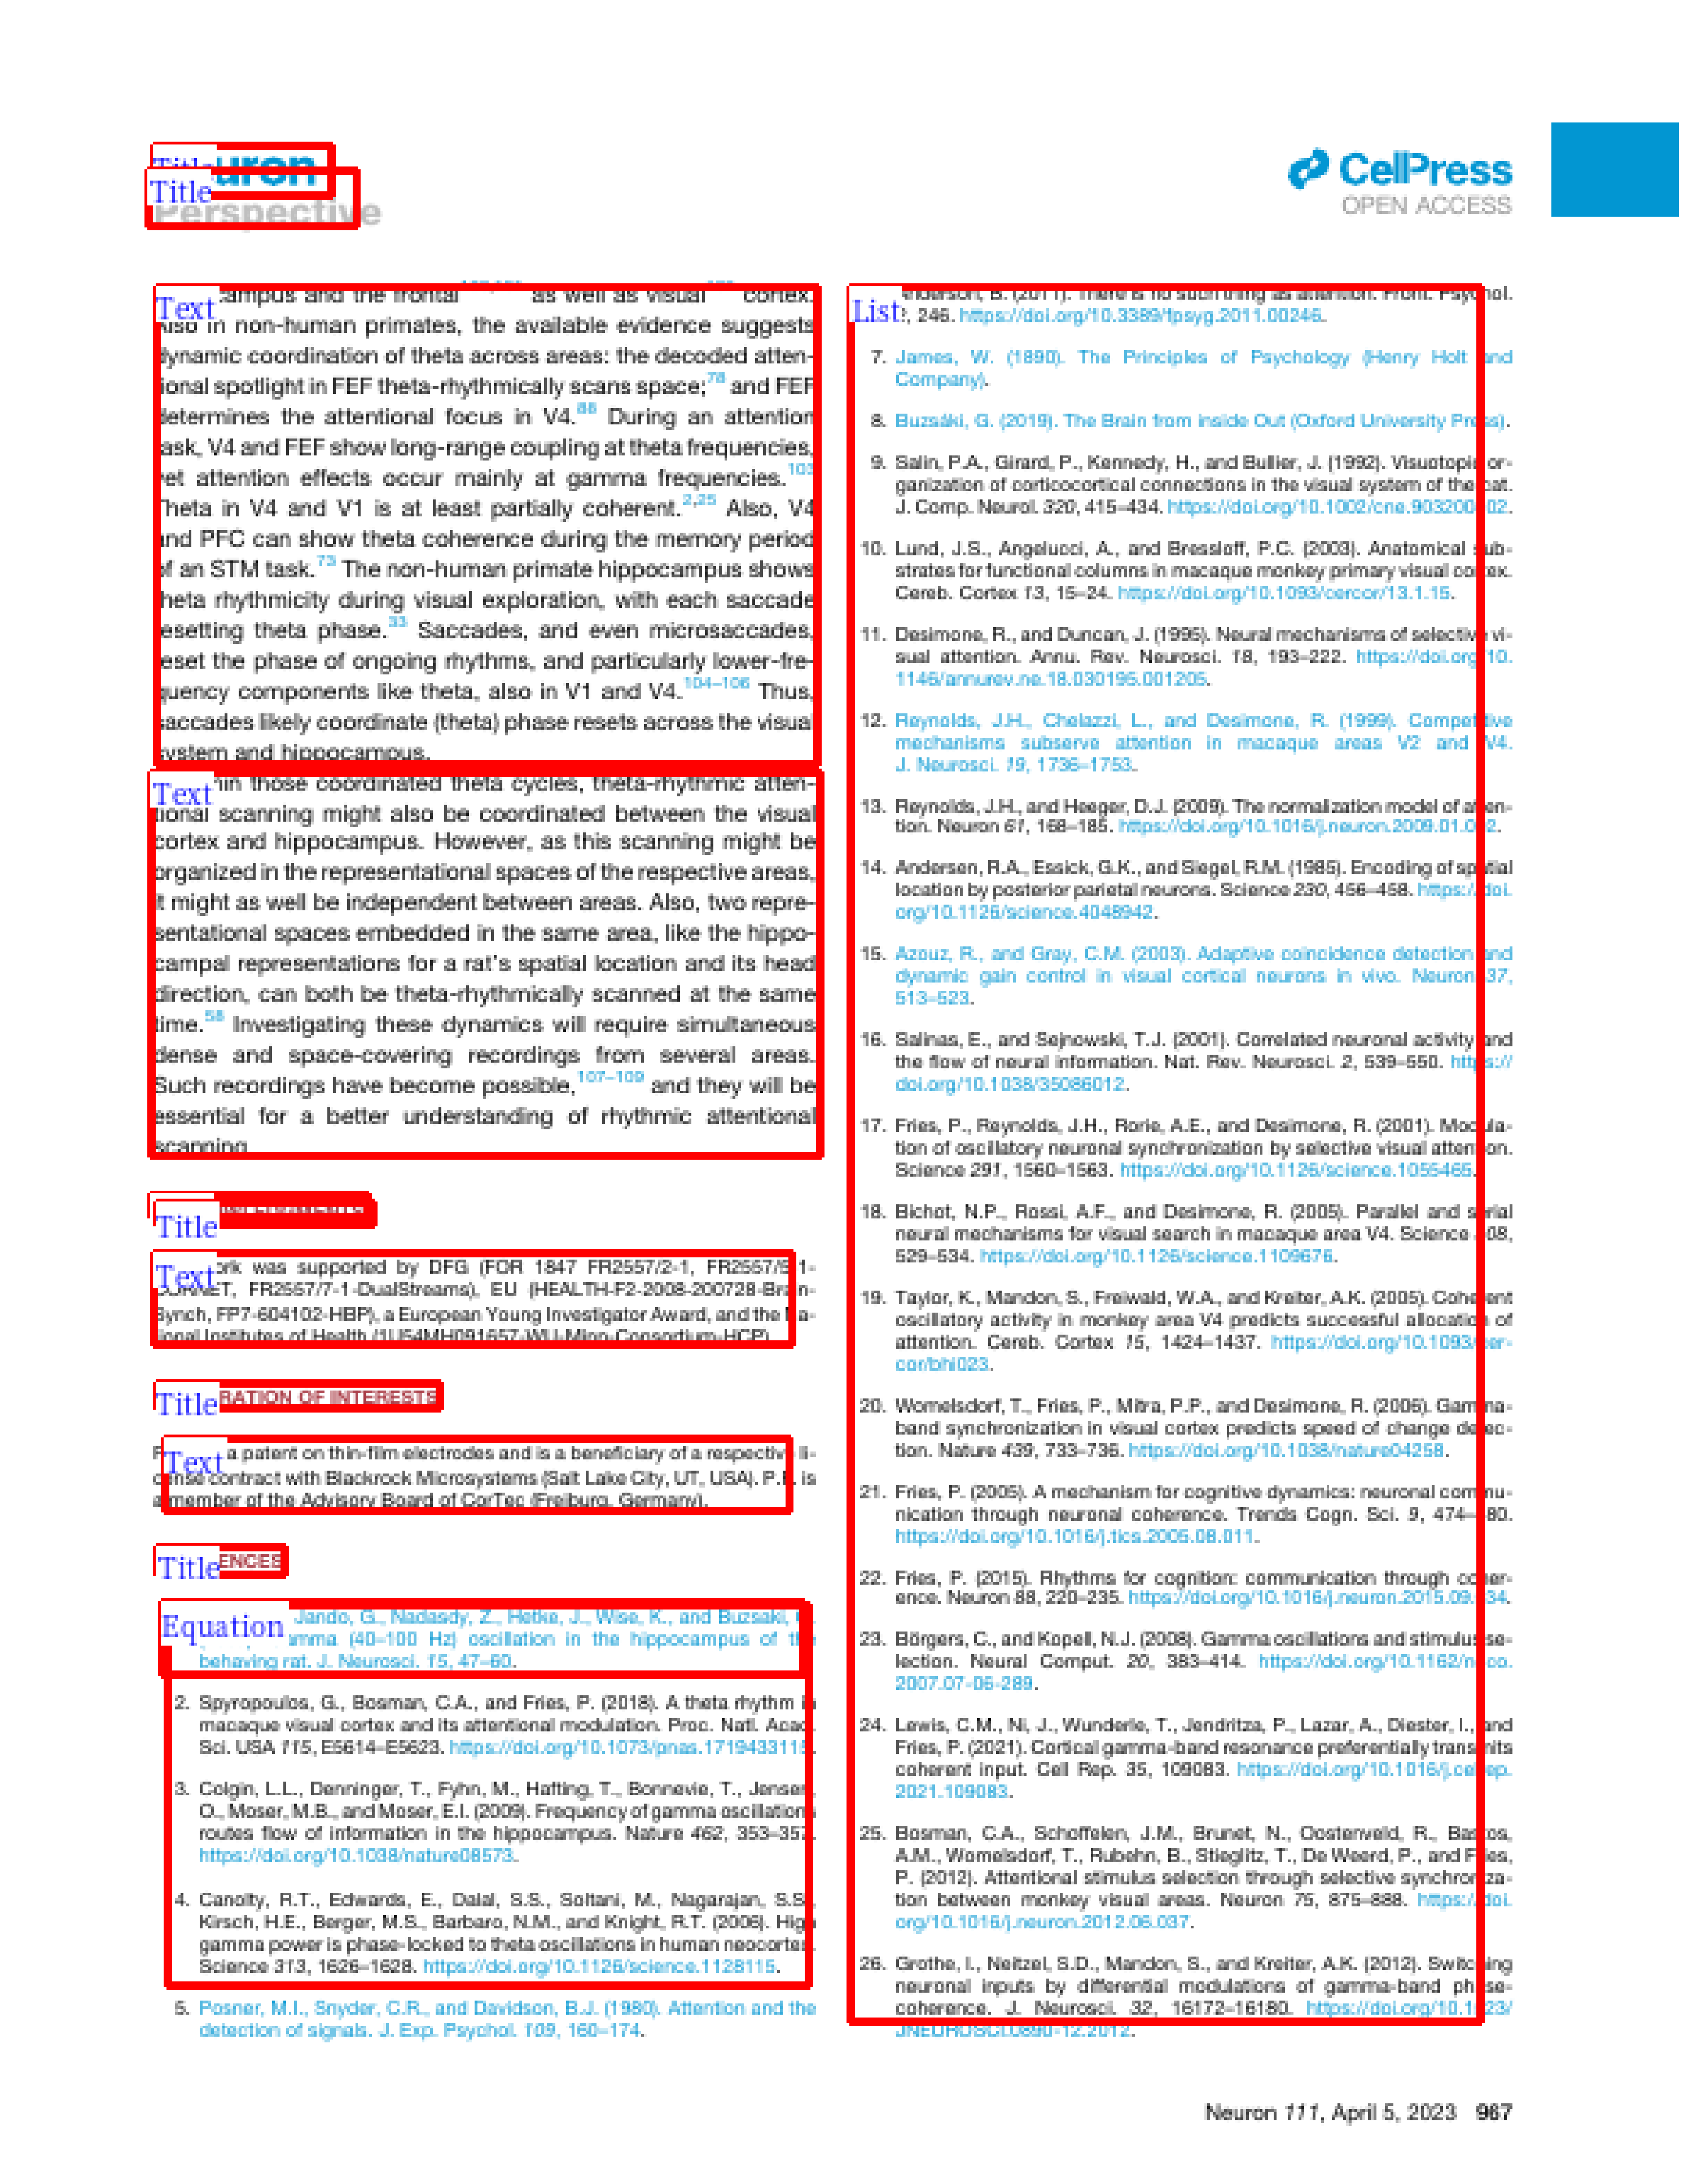

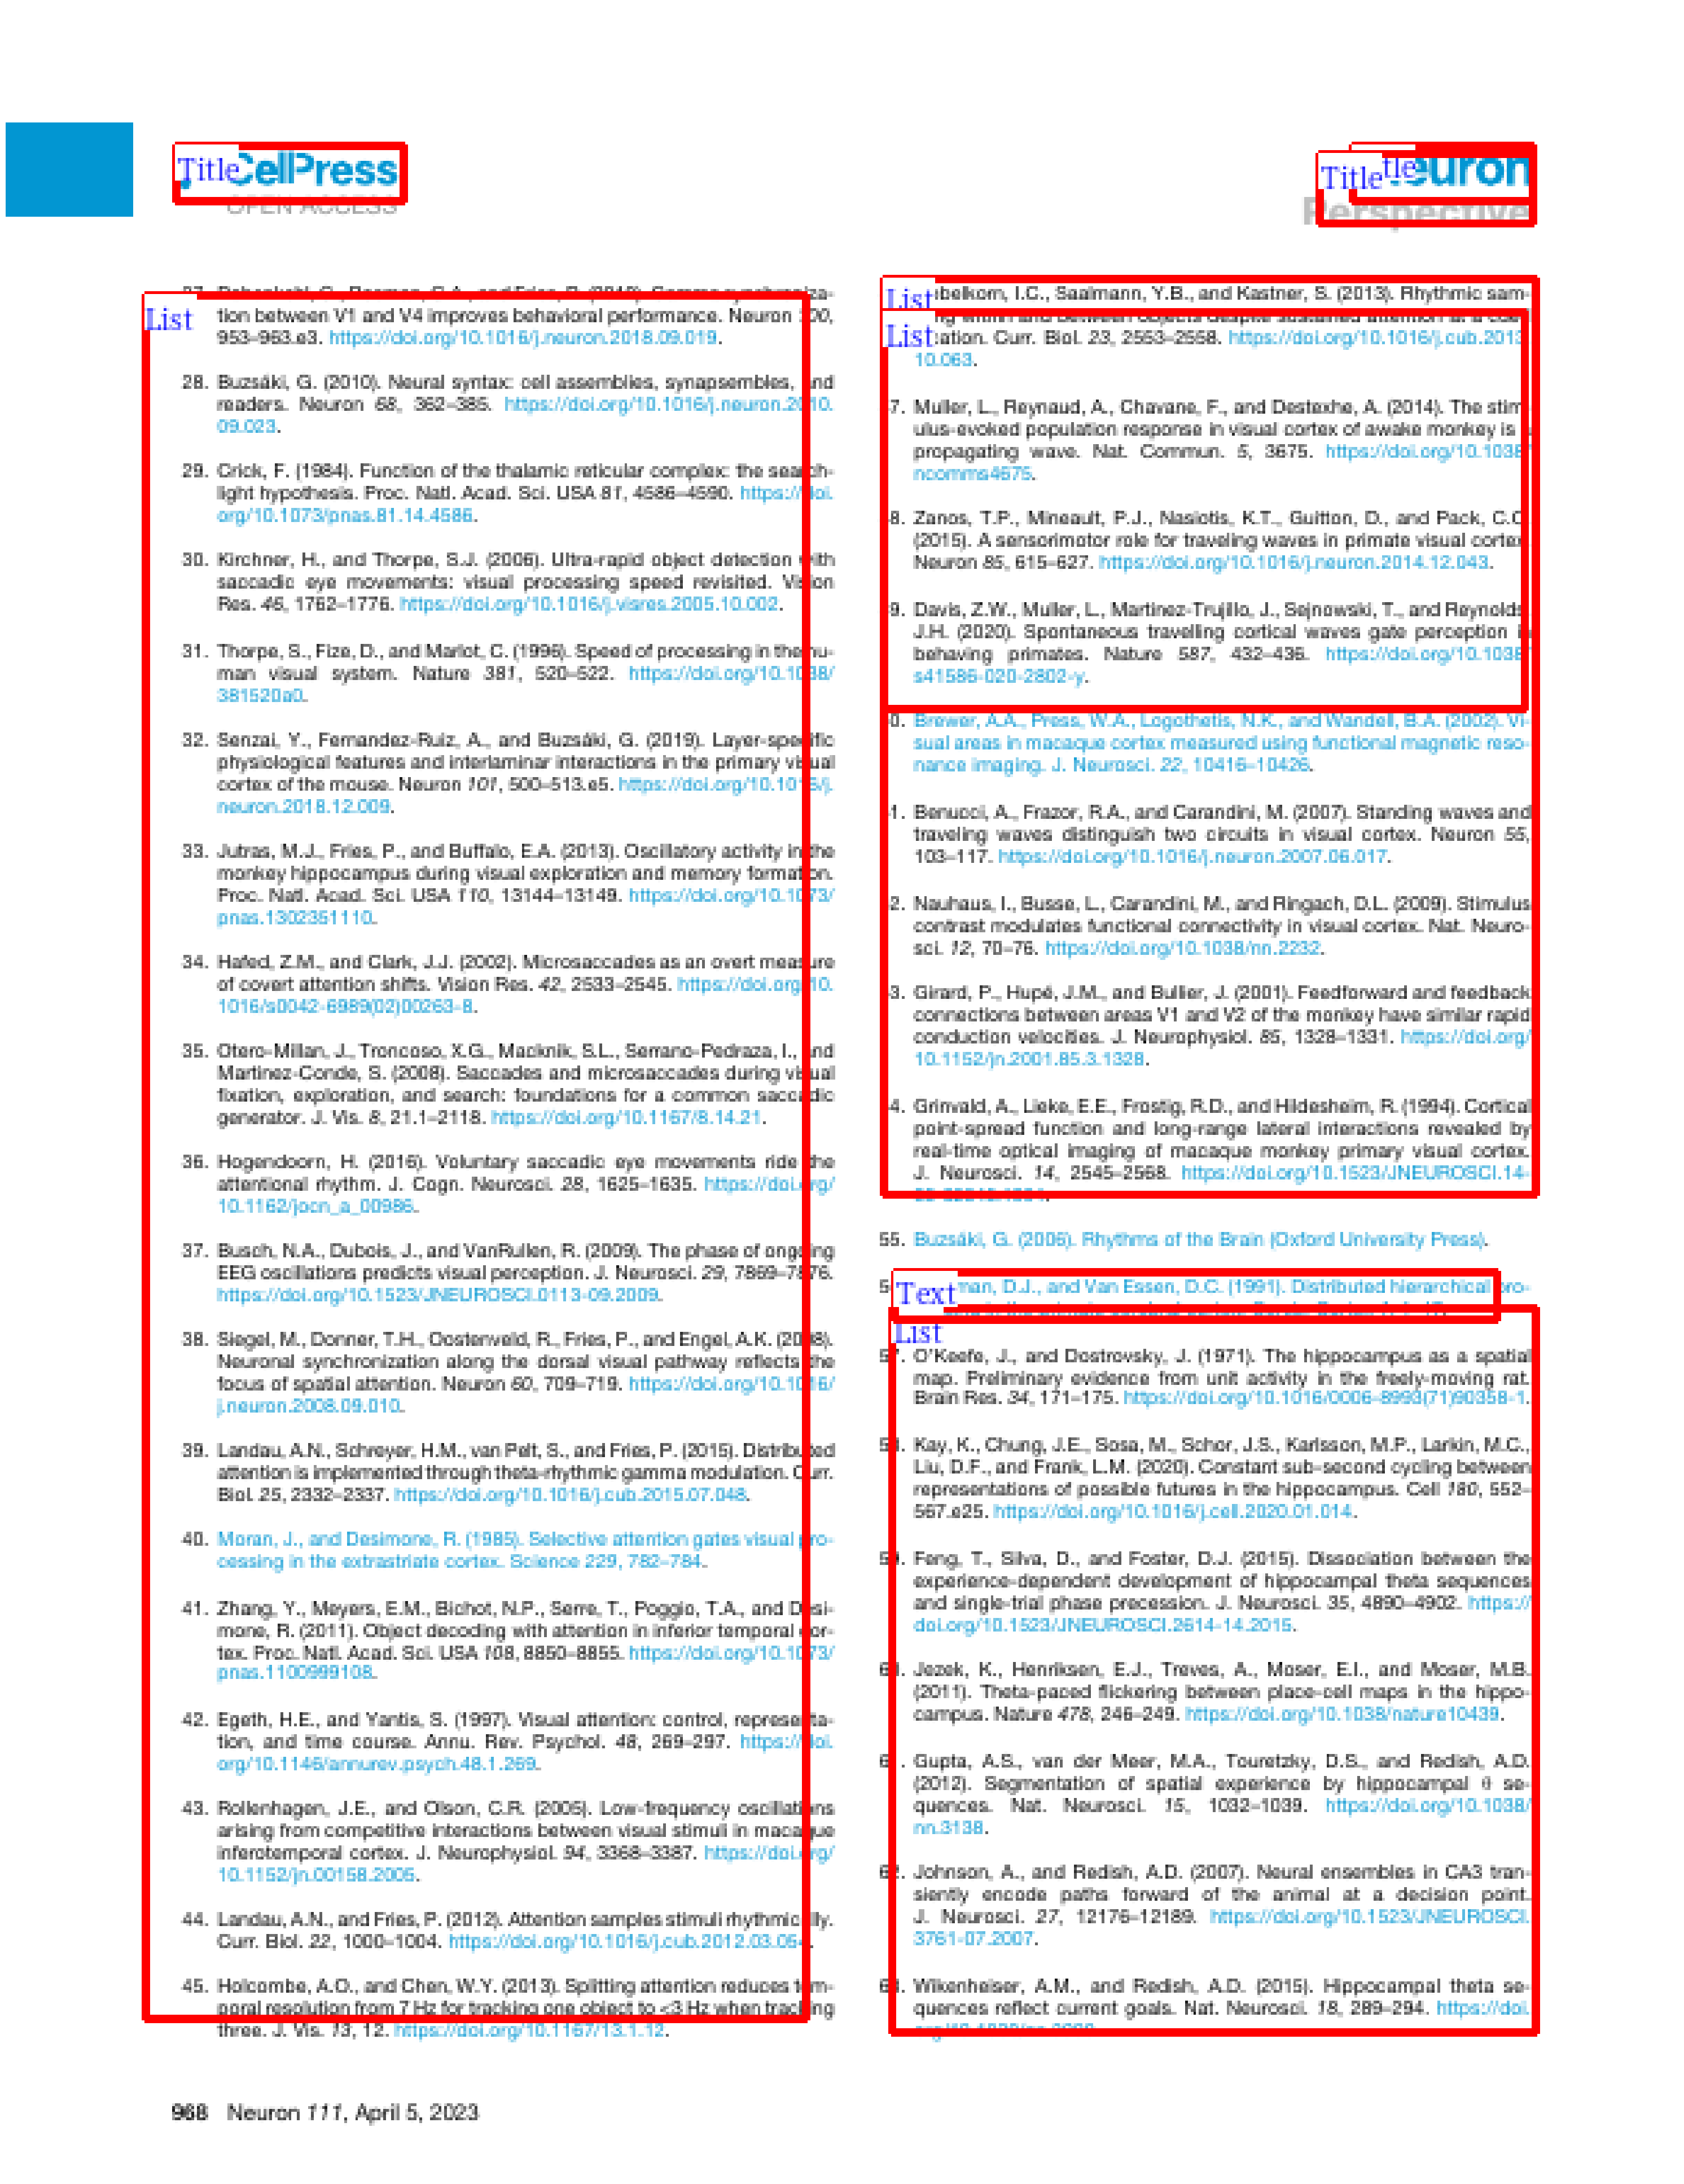

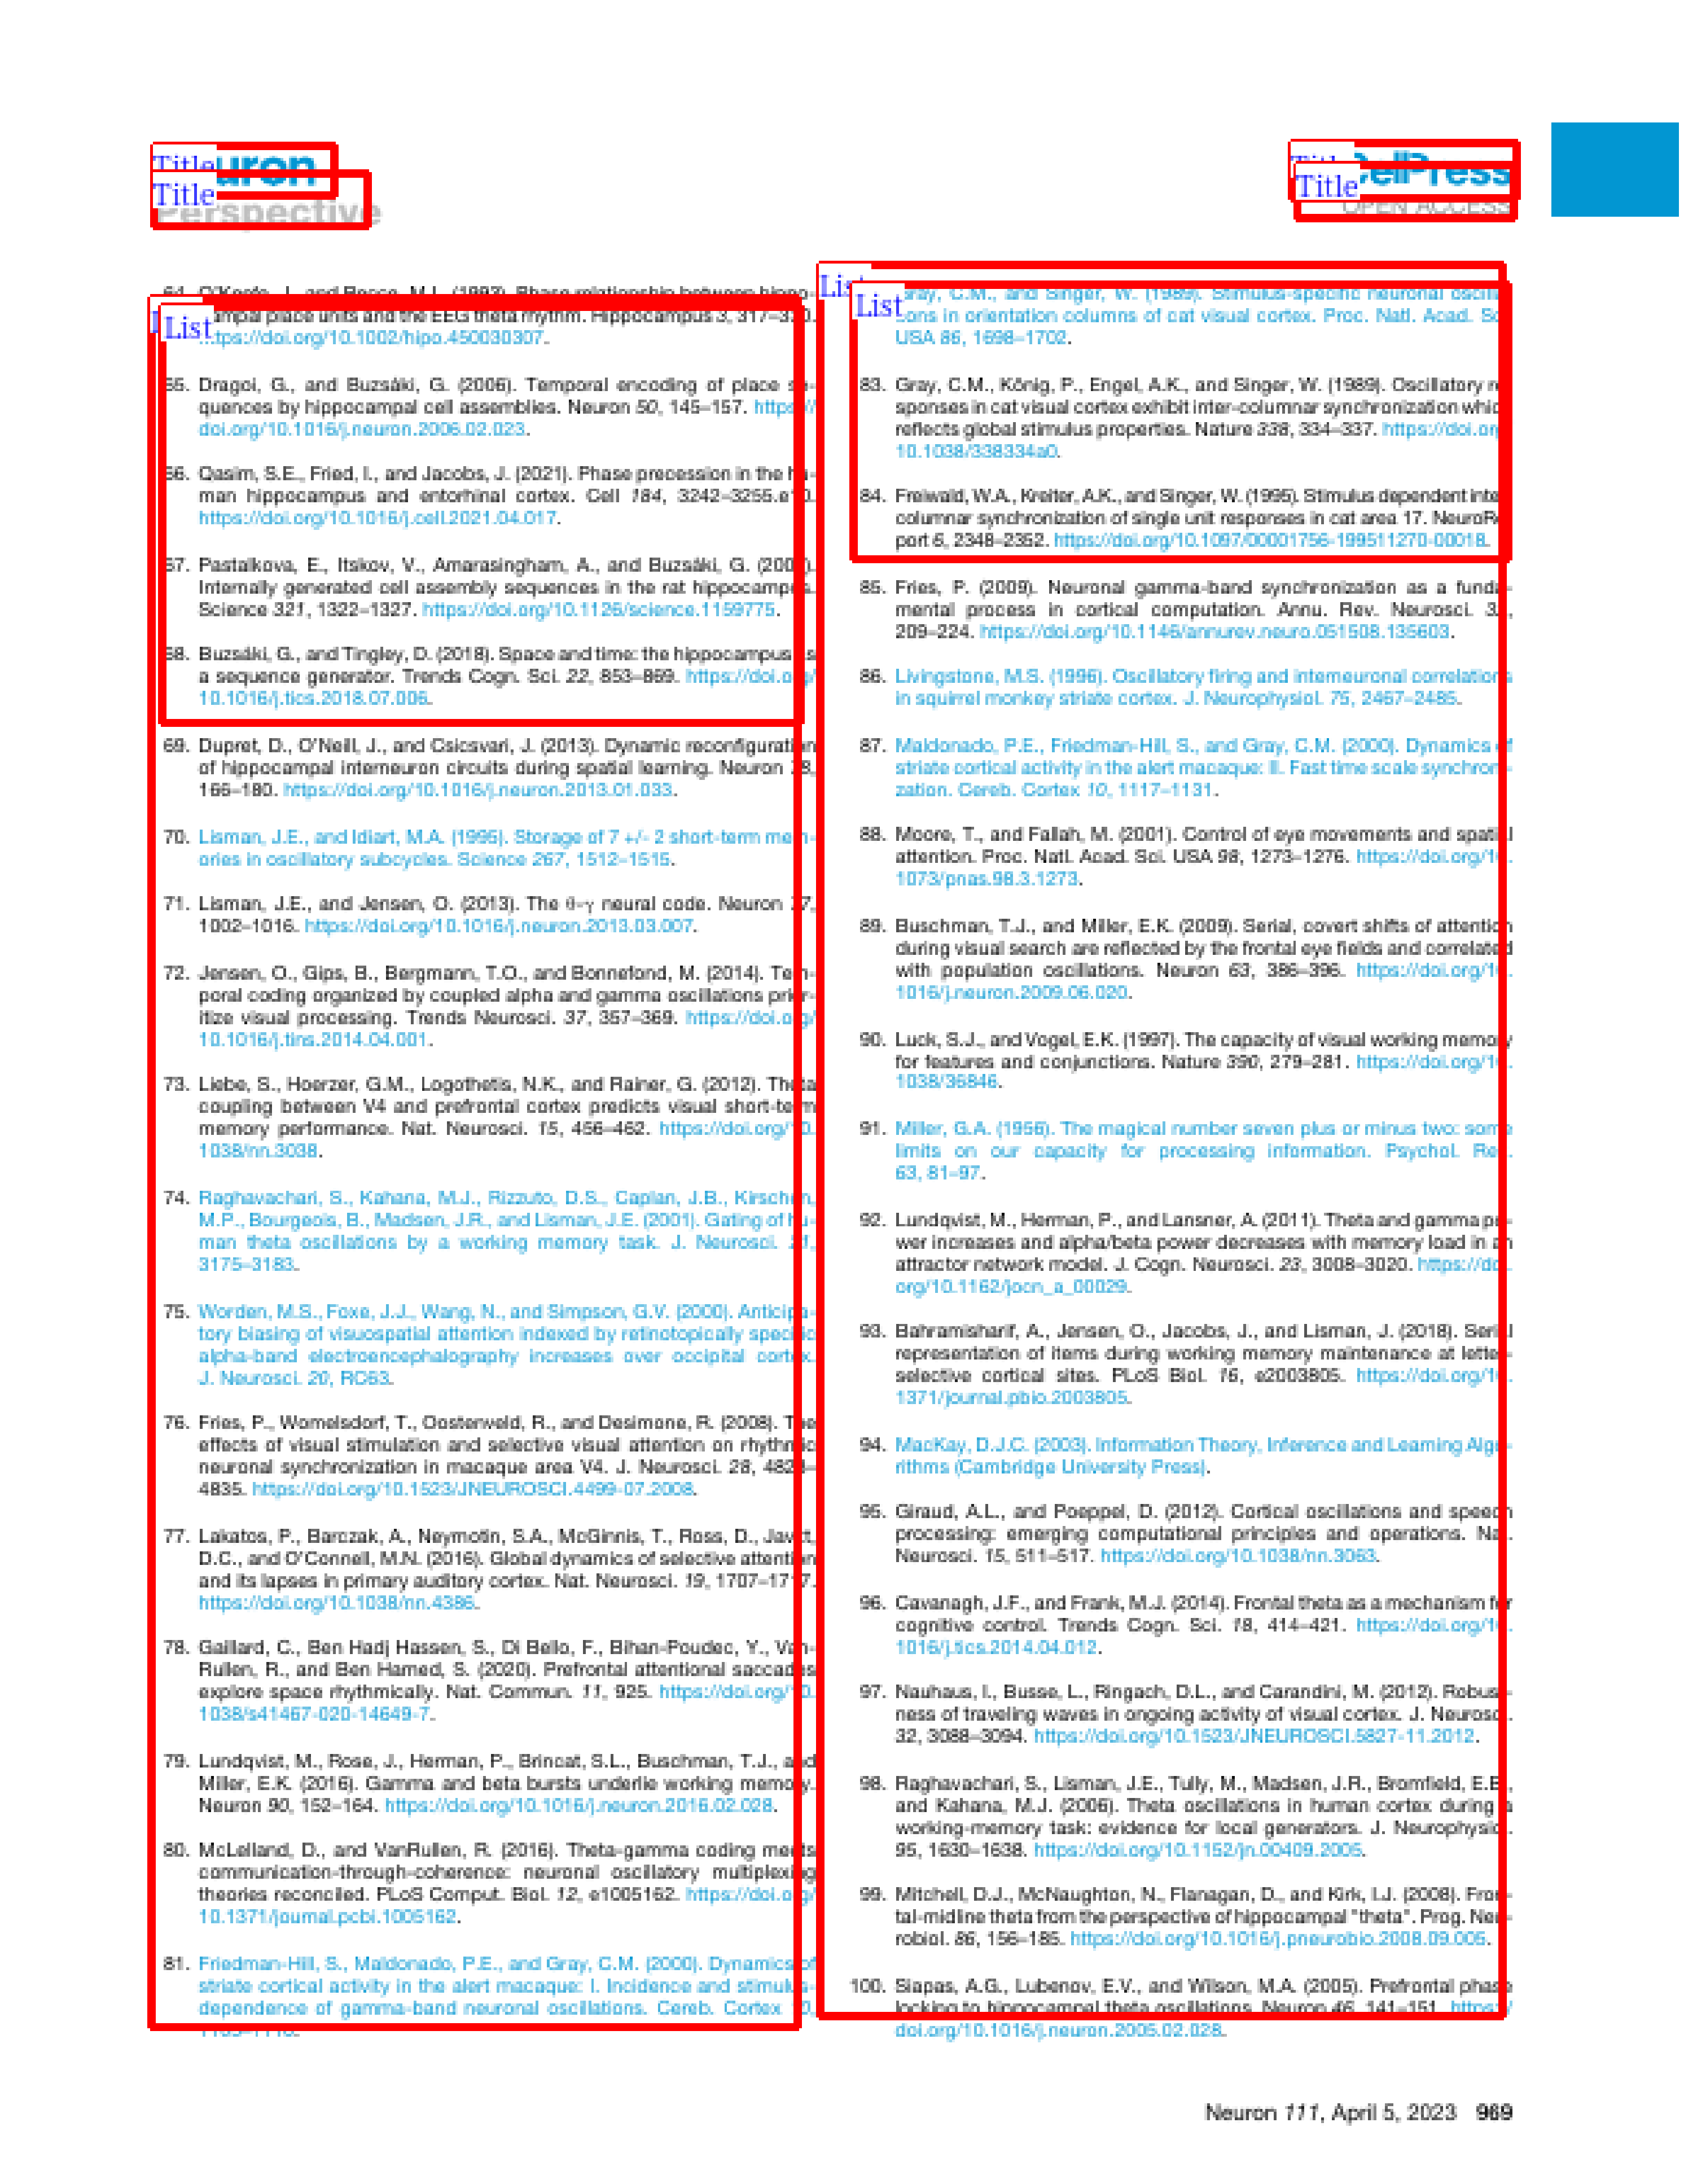

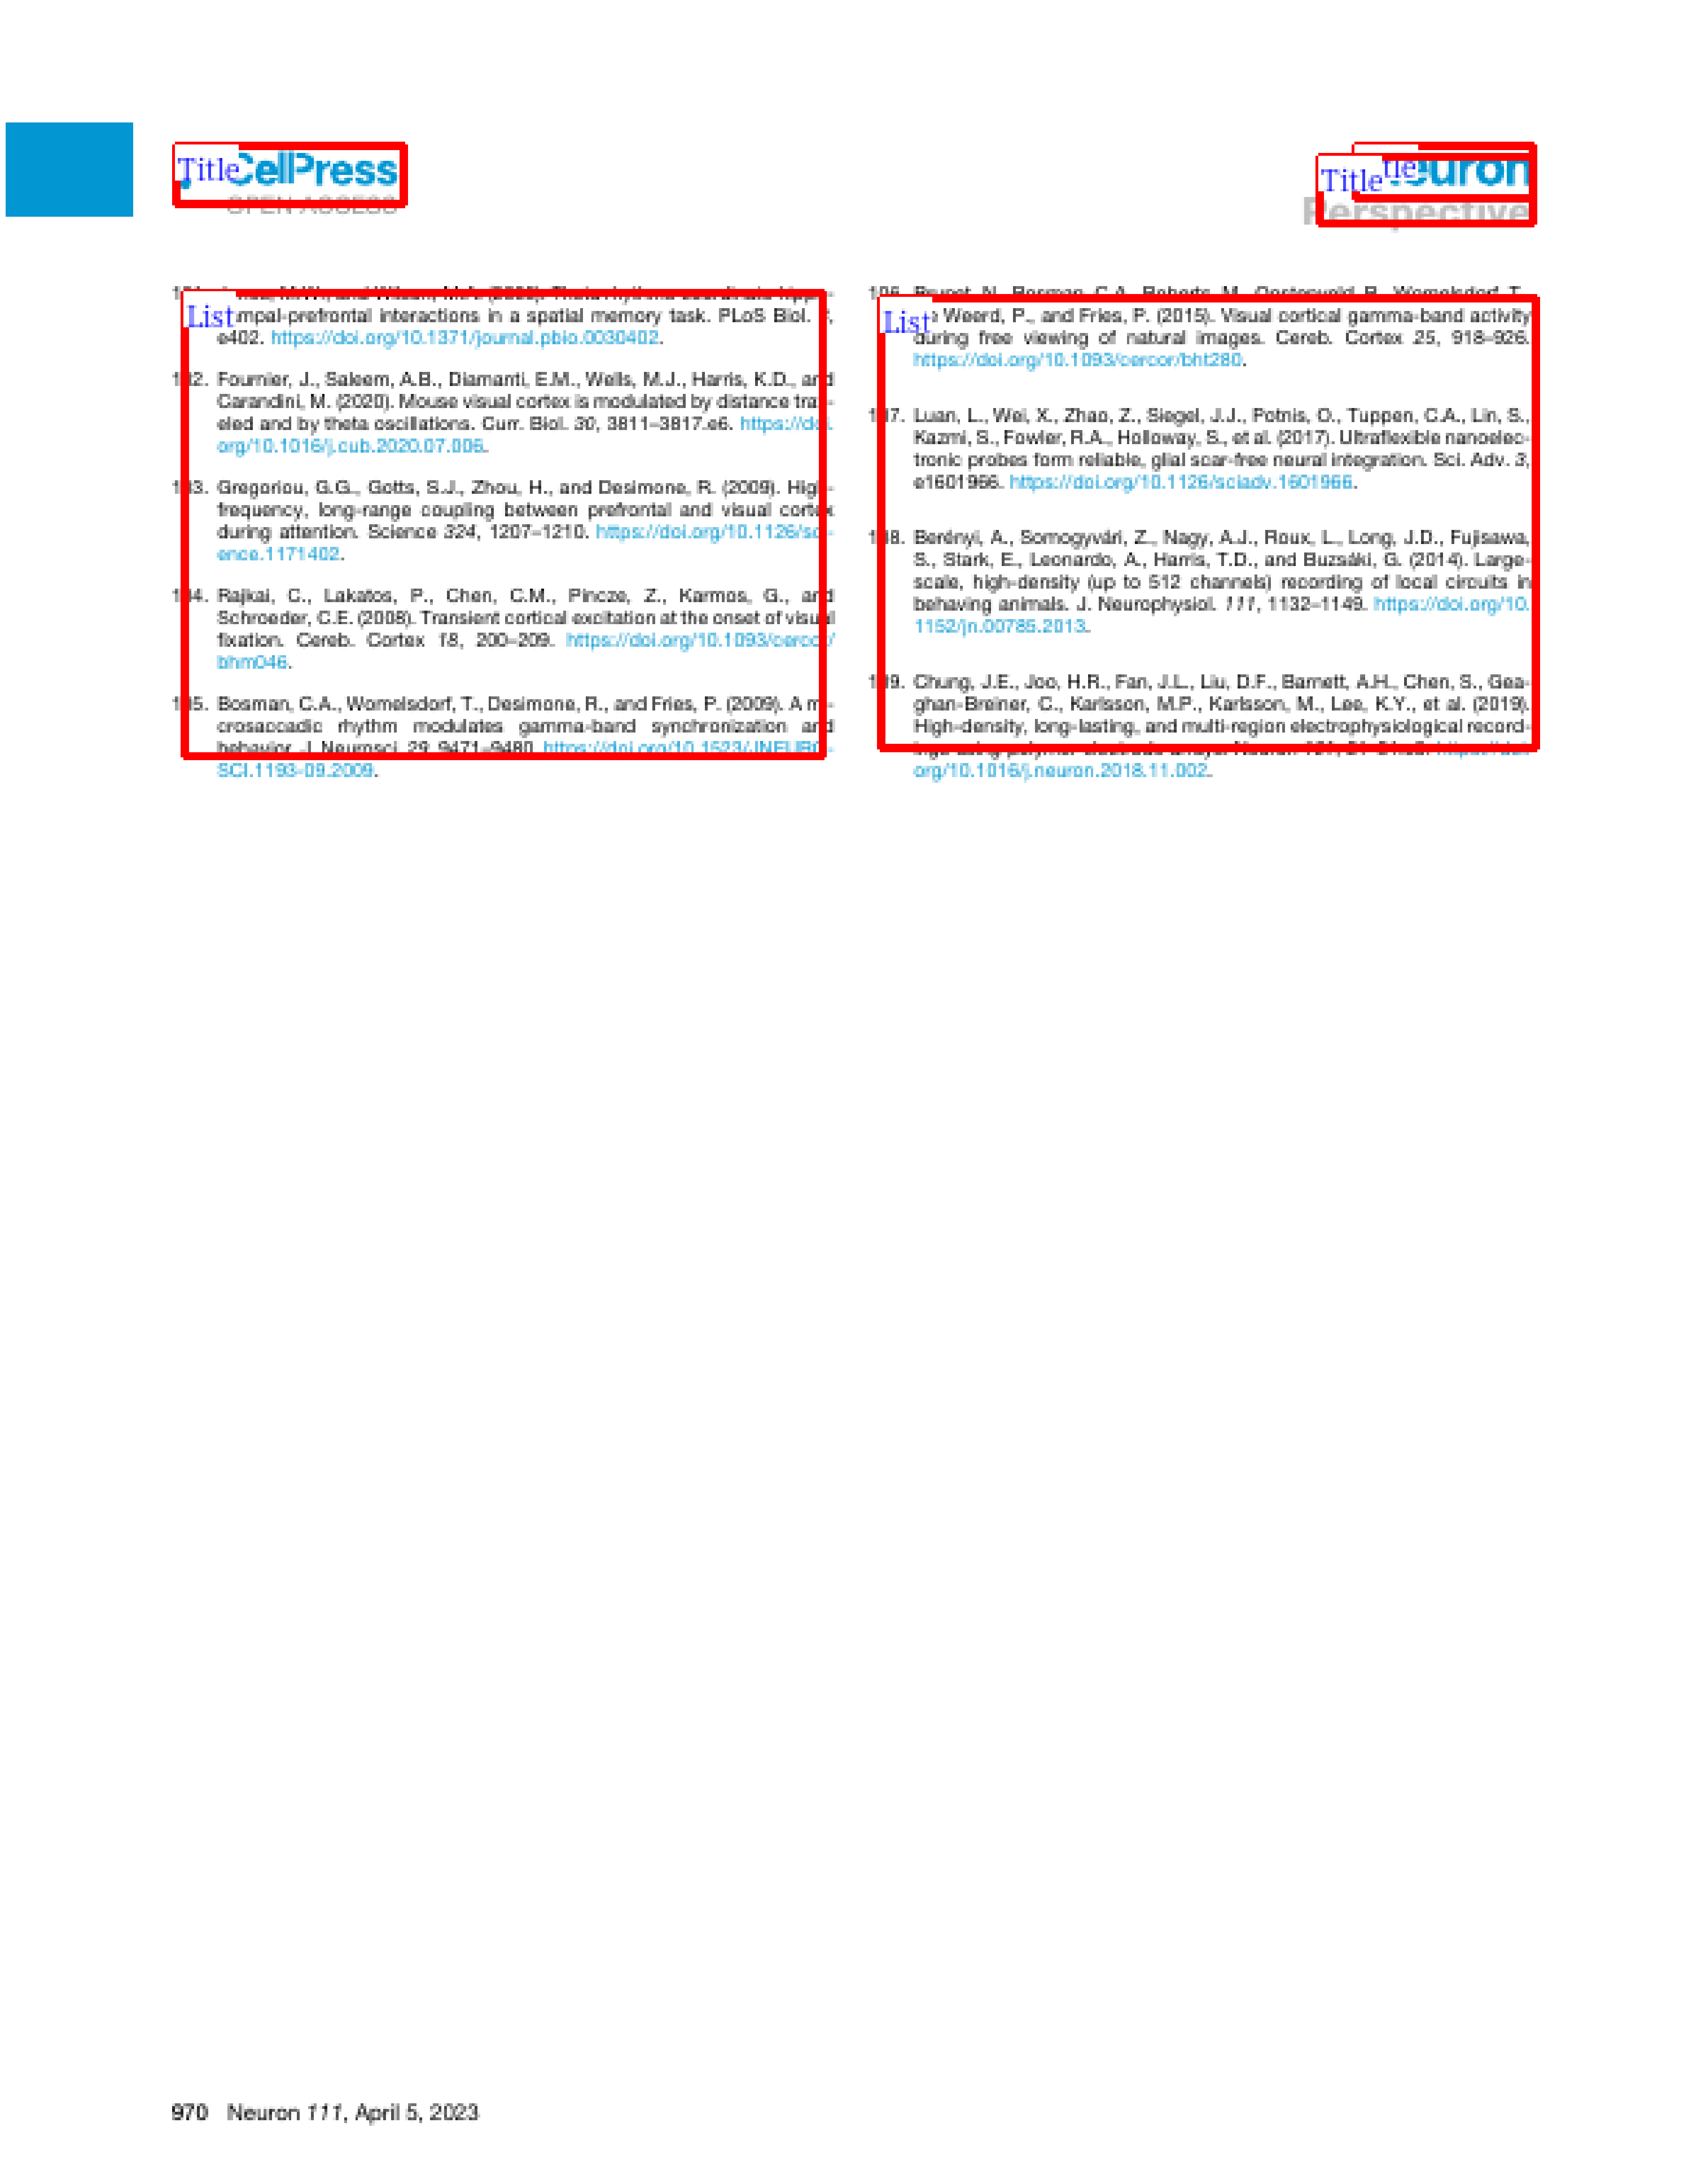

In [7]:
rows = 1
# columns = 2
columns = 1
fontsize = 48


lp_text_blocks = make_rectangles(box_groups, doc)


for i, _ in enumerate(doc.pages):
    fig = plt.figure(figsize=(50, 50))
    fig.add_subplot(rows, columns, 1)
    plt.axis('off')
    if i == 0:
        plt.title("LP Blocks",fontdict={'fontsize': fontsize})
    plt.imshow(draw_text_blocks(i, lp_text_blocks)) 

In [8]:
# errors w/ spangroup overlap when using publaynet weights
doc.annotate(blocks=box_groups)

ValueError: Detected overlap with existing SpanGroup(s) [(86973, 87127, 205), (87063, 87064, 206)] for <mmda.types.annotation.SpanGroup object at 0x28beb9fd0>